In [1]:
import snowflake.connector
import sys
import pandas as pd
import numpy as np
import re
import json
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [2]:
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 100

In [3]:
plt.rcParams["figure.figsize"] = (10,8)
plt.style.use('seaborn-darkgrid')

In [4]:
con = snowflake.connector.connect(
    user="tliang@endpointclosing.com",
    account="endpoint",
    authenticator="externalbrowser",
    role="SNOWFLAKE_DATA_ENGINEERING",
    warehouse="DATAENGINEERING_WH"
)
cur = con.cursor()

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...


In [5]:
query = "SELECT * FROM LAKE.SALESFORCE.LEAD"
lead = cur.execute(query).fetch_pandas_all().reset_index()

In [6]:
# lead[lead['IS_DELETED'] == False]

In [7]:
states = {
    'AK': 'Alaska',
    'AL': 'Alabama',
    'AR': 'Arkansas',
    'AS': 'American Samoa',#
    'AZ': 'Arizona',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DC': 'District of Columbia',
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'GU': 'Guam',#
    'HI': 'Hawaii',
    'IA': 'Iowa',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'MA': 'Massachusetts',
    'MD': 'Maryland',
    'ME': 'Maine',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MO': 'Missouri',
    'MP': 'Northern Mariana Islands',#
    'MS': 'Mississippi',
    'MT': 'Montana',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'NE': 'Nebraska',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NV': 'Nevada',
    'NY': 'New York',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'PR': 'Puerto Rico',#
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VA': 'Virginia',
    'VI': 'Virgin Islands',#
    'VT': 'Vermont',
    'WA': 'Washington',
    'WI': 'Wisconsin',
    'WV': 'West Virginia',
    'WY': 'Wyoming'
}

def state_std(x:str):

    if x is None:
        return ""

    elif (len(x) == 2) & (x.isalpha()):
        return x.upper()
    else:
        for key, value in states.items():
            if x.lower() == value.lower():
                return key
        return ""


In [8]:
lead["STATE_STD"] = lead["STATE"].apply(state_std)

In [9]:
# check the prop of NAs and flag each column
for col in lead.columns:
    num_empty = lead[col].isnull().sum()
    prop = num_empty / len(lead)
    print("{} Column: {:20} -- % Missing: {:.4f}".format("!" if prop > 0.3 else "",col,prop)) # try to align the dash to make the number aligned

 Column: index                -- % Missing: 0.0000
 Column: ID                   -- % Missing: 0.0000
 Column: IS_DELETED           -- % Missing: 0.0000
! Column: MASTER_RECORD_ID     -- % Missing: 0.9996
 Column: LAST_NAME            -- % Missing: 0.0000
 Column: FIRST_NAME           -- % Missing: 0.0003
! Column: SALUTATION           -- % Missing: 0.9991
! Column: MIDDLE_NAME          -- % Missing: 0.4921
! Column: SUFFIX               -- % Missing: 1.0000
 Column: NAME                 -- % Missing: 0.0000
 Column: RECORD_TYPE_ID       -- % Missing: 0.0009
! Column: TITLE                -- % Missing: 0.9992
! Column: COMPANY              -- % Missing: 0.3747
 Column: STREET               -- % Missing: 0.0085
 Column: CITY                 -- % Missing: 0.0248
 Column: STATE                -- % Missing: 0.0062
 Column: POSTAL_CODE          -- % Missing: 0.0253
! Column: COUNTRY              -- % Missing: 0.9998
! Column: LATITUDE             -- % Missing: 0.9999
! Column: LONGITUDE    

### Washington Market 

In [10]:
lead.groupby("STATE_STD")["STATUS"].value_counts()

STATE_STD  STATUS      
           New               4157
           Disqualified       418
           Working            202
           Committed          133
AK         New                  3
AL         New                  2
AR         New                  3
AZ         New              56376
           Disqualified      1813
           Working           1533
           Committed         1270
CA         New             188102
           Committed         2961
           Disqualified      2365
           Working           1616
CO         New                406
           Committed            4
           Disqualified         1
CT         New                  4
DC         New                  3
DE         New                  1
FL         New             264953
           Committed           16
           Working              8
           Disqualified         6
GA         New                 29
           Committed            7
HI         New                 19
           Committed    

In [11]:
lead[(lead["IS_DELETED"] == False)]["STATUS"].value_counts()

New             479495
Committed         8876
Disqualified      7741
Working           4249
Name: STATUS, dtype: int64

In [12]:
wa_lead = lead[(lead["IS_DELETED"] == False)& (lead["STATE_STD"] == "WA")& (lead["STATUS"]!= "New")]

In [13]:
wa_lead.to_csv("wa_lead.csv")

In [14]:
wa_lead["STATUS"].value_counts()

Committed       3726
Disqualified    2795
Working          408
Name: STATUS, dtype: int64

In [15]:
wa_lead[wa_lead["CONVERTED_CONTACT_ID"].notnull()]["STATUS"].value_counts()

Committed       3649
Disqualified     417
Name: STATUS, dtype: int64

In [16]:
wa_lead[wa_lead["STATUS"] == 'Committed']["APEX_PROCESSED_C"].value_counts()

False    2109
True     1617
Name: APEX_PROCESSED_C, dtype: int64

In [17]:
wa_lead["LEVEL_VETTING_C"].value_counts()

Level 2 - 4+ listings/yr             2093
Level 3 - Less than 4 listings/yr    1895
Level 1 - 10+ listings/yr            1883
Level Platinum 30+ Listings/yr         50
Level Gold 20-29 Listings/yr           46
Name: LEVEL_VETTING_C, dtype: int64

In [18]:
wa_lead[wa_lead["STATUS"] != "New"].groupby("LEVEL_VETTING_C")["STATUS"].value_counts()

LEVEL_VETTING_C                    STATUS      
Level 1 - 10+ listings/yr          Disqualified    1014
                                   Committed        781
                                   Working           88
Level 2 - 4+ listings/yr           Committed       1034
                                   Disqualified     954
                                   Working          105
Level 3 - Less than 4 listings/yr  Committed       1197
                                   Disqualified     561
                                   Working          137
Level Gold 20-29 Listings/yr       Disqualified      32
                                   Working            9
                                   Committed          5
Level Platinum 30+ Listings/yr     Disqualified      33
                                   Working           15
                                   Committed          2
Name: STATUS, dtype: int64

In [19]:
wa_lead.columns.to_list()

['index',
 'ID',
 'IS_DELETED',
 'MASTER_RECORD_ID',
 'LAST_NAME',
 'FIRST_NAME',
 'SALUTATION',
 'MIDDLE_NAME',
 'SUFFIX',
 'NAME',
 'RECORD_TYPE_ID',
 'TITLE',
 'COMPANY',
 'STREET',
 'CITY',
 'STATE',
 'POSTAL_CODE',
 'COUNTRY',
 'LATITUDE',
 'LONGITUDE',
 'GEOCODE_ACCURACY',
 'PHONE',
 'MOBILE_PHONE',
 'FAX',
 'EMAIL',
 'WEBSITE',
 'PHOTO_URL',
 'DESCRIPTION',
 'LEAD_SOURCE',
 'STATUS',
 'INDUSTRY',
 'RATING',
 'ANNUAL_REVENUE',
 'NUMBER_OF_EMPLOYEES',
 'OWNER_ID',
 'HAS_OPTED_OUT_OF_EMAIL',
 'IS_CONVERTED',
 'CONVERTED_DATE',
 'CONVERTED_ACCOUNT_ID',
 'CONVERTED_CONTACT_ID',
 'CONVERTED_OPPORTUNITY_ID',
 'IS_UNREAD_BY_OWNER',
 'CREATED_DATE',
 'CREATED_BY_ID',
 'LAST_MODIFIED_DATE',
 'LAST_MODIFIED_BY_ID',
 'SYSTEM_MODSTAMP',
 'LAST_ACTIVITY_DATE',
 'DO_NOT_CALL',
 'HAS_OPTED_OUT_OF_FAX',
 'LAST_VIEWED_DATE',
 'LAST_REFERENCED_DATE',
 'LAST_TRANSFER_DATE',
 'JIGSAW',
 'JIGSAW_CONTACT_ID',
 'EMAIL_BOUNCED_REASON',
 'EMAIL_BOUNCED_DATE',
 'INDIVIDUAL_ID',
 'POSTAL_CODE_C',
 'MOST_RE

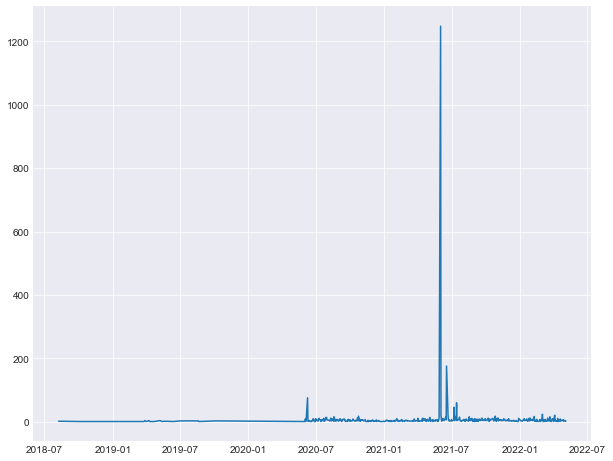

In [20]:
wa_lead["CONVERTED_DATE"].value_counts().plot()
plt.show()

In [21]:
wa_lead.groupby("APEX_PROCESSED_C")["STATUS"].value_counts()

APEX_PROCESSED_C  STATUS      
False             Disqualified    2401
                  Committed       2109
                  Working          408
True              Committed       1617
                  Disqualified     394
Name: STATUS, dtype: int64

#### Lead History

In [22]:
# list history
query = "SELECT * FROM LAKE.SALESFORCE.LEAD_HISTORY"
lead_hist = cur.execute(query).fetch_pandas_all().reset_index()

In [23]:
wa_lead_hist = lead_hist[(lead_hist["LEAD_ID"].isin(wa_lead["ID"])) & (lead_hist["IS_DELETED"] == False)]

In [24]:
wa_lead_hist_cutoff = wa_lead_hist[(wa_lead_hist["CREATED_DATE"].dt.date >= dt.date(2021,6,1))& (wa_lead_hist["CREATED_DATE"].dt.date < dt.date(2021,12,1))]

In [25]:
# wa_lead_hist_cutoff.to_csv("wa_lead_hist_cutoff.csv")

In [27]:
wa_lead_hist["LEAD_ID"].nunique()

6747

In [28]:
wa_lead_hist.head(10)

,index,ID,IS_DELETED,LEAD_ID,CREATED_BY_ID,CREATED_DATE,FIELD,DATA_TYPE,OLD_VALUE,NEW_VALUE,_FIVETRAN_SYNCED
11,11,0171H00014yGtEuQAK,False,00Q1H00001FdH2sUAF,0051H00000AeGKuQAN,2021-09-17 15:07:01-07:00,Last_Modified__c,DateOnly,2021-09-16,2021-09-17,2021-09-17 19:41:46.655000-07:00
44,44,0171H00014yH2kSQAS,False,00Q1H00001FdLKDUA3,0051H000008sMEFQA2,2021-09-17 17:05:01-07:00,Last_Modified__c,DateOnly,2021-09-13,2021-09-17,2021-09-17 19:41:46.650000-07:00
65,65,0171H00014yGZ6GQAW,False,00Q1H00001EwgcrUAB,0051H00000BQg3LQAT,2021-09-17 14:58:40-07:00,FA_Loyal_Lead__c,DynamicEnum,Yes,No,2021-09-17 19:41:46.662000-07:00
125,125,0171H00014yGkIxQAK,False,00Q1H00001Cq6gzUAB,0051H00000AeGKuQAN,2021-09-17 14:25:01-07:00,Last_Modified__c,DateOnly,2021-09-14,2021-09-17,2021-09-17 19:41:46.658000-07:00
138,138,0171H00014yGZ6HQAW,False,00Q1H00001EwgcrUAB,0051H00000BQg3LQAT,2021-09-17 14:58:40-07:00,FA_Loyal_Lead__c,DynamicEnum,No,Yes,2021-09-17 19:41:46.662000-07:00
174,174,0171H00014yGzvdQAC,False,00Q1H00001EwhVxUAJ,0051H00000AeGKuQAN,2021-09-17 16:14:18-07:00,Last_Modified__c,DateOnly,2021-09-16,2021-09-17,2021-09-17 19:41:46.650000-07:00
190,190,0171H00014yGs7bQAC,False,00Q1H00001EwgcrUAB,0051H000008sMEFQA2,2021-09-17 14:58:10-07:00,Owner,Text,Unassigned Lead,Jordon Turpen,2021-09-17 19:41:46.648000-07:00
283,283,0171H00014yGfozQAC,False,00Q1H00001CrpWvUAJ,0051H00000AeGKuQAN,2021-09-17 14:10:32-07:00,Last_Modified__c,DateOnly,2021-09-16,2021-09-17,2021-09-17 19:41:46.661000-07:00
294,294,0171H00014yGg4bQAC,False,00Q1H00001EwgJJUAZ,0051H00000AeGKuQAN,2021-09-17 14:10:32-07:00,Last_Modified__c,DateOnly,2021-09-15,2021-09-17,2021-09-17 19:41:46.661000-07:00
302,302,0171H00014yGsP7QAK,False,00Q1H00001EwgcrUAB,0051H000008sMEFQA2,2021-09-17 15:00:21-07:00,MobilePhone,Phone,None,253-350-8682,2021-09-17 19:41:46.662000-07:00


In [29]:
# wa_lead_hist.dtypes

In [30]:
# sample lead for all status history
wa_lead_hist[(wa_lead_hist["LEAD_ID"] == '00Q1H00001CsLjeUAF') & (wa_lead_hist["FIELD"] == 'Status')].sort_values(by = "CREATED_DATE")

,index,ID,IS_DELETED,LEAD_ID,CREATED_BY_ID,CREATED_DATE,FIELD,DATA_TYPE,OLD_VALUE,NEW_VALUE,_FIVETRAN_SYNCED
1077573,15344,0171H0000x49h0oQAA,False,00Q1H00001CsLjeUAF,0051H00000A36H7QAJ,2020-05-28 13:32:11-07:00,Status,DynamicEnum,Disqualified,Working,2021-09-07 17:03:15.928000-07:00
2194277,30665,0171H0000x49hZ1QAI,False,00Q1H00001CsLjeUAF,0051H00000A36H7QAJ,2020-05-28 13:36:44-07:00,Status,DynamicEnum,Working,New,2021-09-07 17:03:15.925000-07:00
1125449,8301,0171H0000xdiOt5QAE,False,00Q1H00001CsLjeUAF,0051H000008rwTGQAY,2020-06-29 22:42:02-07:00,Status,DynamicEnum,New,Disqualified,2021-09-07 17:03:04.260000-07:00
2323239,59193,0171H0000xhm7mUQAQ,False,00Q1H00001CsLjeUAF,0051H000008rwTGQAY,2020-07-02 11:58:13-07:00,Status,DynamicEnum,Disqualified,New,2021-09-07 17:03:03.992000-07:00
2338937,74891,0171H0000zAoZ0GQAV,False,00Q1H00001CsLjeUAF,0051H000008sMEFQA2,2020-09-18 12:59:43-07:00,Status,DynamicEnum,New,Working,2021-09-07 17:03:03.682000-07:00
2150603,41554,0171H0000zFbx0SQAR,False,00Q1H00001CsLjeUAF,0051H000008sMEFQA2,2020-09-22 10:22:56-07:00,Status,DynamicEnum,Working,Disqualified,2021-09-07 17:03:03.682000-07:00
1519663,101666,0171H00014A8Rh0QAF,False,00Q1H00001CsLjeUAF,0051H000008sMEFQA2,2021-07-13 10:06:58-07:00,Status,DynamicEnum,Working,Disqualified,2021-09-07 17:03:01.627000-07:00
1525313,107316,0171H00014A8RgyQAF,False,00Q1H00001CsLjeUAF,0051H000008sMEFQA2,2021-07-13 10:06:58-07:00,Status,DynamicEnum,Disqualified,Working,2021-09-07 17:03:01.627000-07:00
733124,65815,0171H00014A8ZLpQAN,False,00Q1H00001CsLjeUAF,0051H000008sMEFQA2,2021-07-13 10:33:24-07:00,Status,DynamicEnum,Disqualified,Working,2021-09-07 17:03:01.627000-07:00
1082301,20072,0171H00014A8ZLqQAN,False,00Q1H00001CsLjeUAF,0051H000008sMEFQA2,2021-07-13 10:33:24-07:00,Status,DynamicEnum,Working,Disqualified,2021-09-07 17:03:01.627000-07:00


In [31]:
wa_lead_hist['FIELD'].unique()

array(['Last_Modified__c', 'FA_Loyal_Lead__c', 'Owner', 'MobilePhone',
       'leadConverted', 'Status', 'Phone', 'Brokerage1__c', 'Email',
       'Level_Vetting__c', 'Disqualified_Reasons__c', 'created',
       'LeadSource', 'Role__c', 'Preferred_Title_Company__c',
       'leadMerged', 'Total_Listing_Count__c',
       'Preferred_Escrow_Company__c', 'Total_Transaction_Count__c',
       'Relationship_Manager__c', 'Disqualified_Notes__c',
       'ownerAssignment', 'License_No__c', 'Average_Close_Price__c',
       'App_Download_Date__c', 'Product_Demo_Date__c'], dtype=object)

In [32]:
wa_lead_hist.sort_values(by = ["LEAD_ID","CREATED_DATE"])

,index,ID,IS_DELETED,LEAD_ID,CREATED_BY_ID,CREATED_DATE,FIELD,DATA_TYPE,OLD_VALUE,NEW_VALUE,_FIVETRAN_SYNCED
1414568,197122,0171H0000zECAy2QAH,False,00Q1H000013ysKgUAI,0051H00000A36H7QAJ,2020-09-21 09:33:58-07:00,Owner,Text,Garreth Long,John Kirkpatrick,2021-09-07 17:02:58.680000-07:00
1414837,197391,0171H0000zECAy4QAH,False,00Q1H000013ysKgUAI,0051H00000A36H7QAJ,2020-09-21 09:33:58-07:00,Last_Modified__c,DateOnly,None,2020-09-21,2021-09-07 17:03:48.546000-07:00
2351830,87784,0171H0000zECAy3QAH,False,00Q1H000013ysKgUAI,0051H00000A36H7QAJ,2020-09-21 09:33:58-07:00,Owner,EntityId,0051H000008zRJ4QAM,0051H00000A36H7QAJ,2021-09-07 17:02:58.680000-07:00
2563132,98745,0171H00010Ps0LuQAJ,False,00Q1H000013ysKgUAI,0051H00000A36H7QAJ,2020-11-18 11:48:29-08:00,Last_Modified__c,DateOnly,2020-09-21,2020-11-18,2021-09-07 17:03:48.169000-07:00
33093,7258,0178V00016W9c0WQAR,False,00Q1H000013ysKgUAI,0051H000008zRJ4QAM,2022-01-10 07:03:14-08:00,Owner,EntityId,0051H00000A36H7QAJ,0051H000008sMEFQA2,2022-01-10 12:41:31.483000-08:00
...,...,...,...,...,...,...,...,...,...,...,...
205862,95887,0178V00018Oes18QAB,False,00Q8V00001NavaCUAR,0051H00000BeVArQAN,2022-05-03 16:40:36-07:00,MobilePhone,Phone,206-258-6097,206-446-3057,2022-05-03 17:41:05.489000-07:00
205854,95879,0178V00018OerkvQAB,False,00Q8V00001NavaCUAR,0051H00000BeVArQAN,2022-05-03 16:44:24-07:00,Owner,EntityId,0051H00000BeVArQAN,0051H00000AeGKuQAN,2022-05-03 17:41:05.489000-07:00
205859,95884,0178V00018OerkuQAB,False,00Q8V00001NavaCUAR,0051H00000BeVArQAN,2022-05-03 16:44:24-07:00,Owner,Text,Kimberly Rathwick,Amanda Bell,2022-05-03 17:41:05.489000-07:00
205822,95847,0178V00018P1ZNzQAN,False,00Q8V00001NavaCUAR,0058V00000C7vv8QAB,2022-05-03 23:18:23-07:00,leadConverted,Text,None,None,2022-05-03 23:41:00.382000-07:00


In [33]:
wa_lead_hist_status = wa_lead_hist[["LEAD_ID","CREATED_DATE","FIELD","OLD_VALUE","NEW_VALUE"]].query("FIELD == 'Status'")

In [34]:
wa_lead_hist_status["VALUE_AGG"] = wa_lead_hist_status["OLD_VALUE"] + "-" + wa_lead_hist_status["NEW_VALUE"]


In [35]:
wa_lead_hist_status = wa_lead_hist_status.sort_values(by = ["LEAD_ID","CREATED_DATE"])

In [36]:
wa_lead_hist_status_agg = wa_lead_hist_status.groupby("LEAD_ID")["VALUE_AGG"].agg(",".join).reset_index()

In [37]:
wa_lead_hist_status_agg

,LEAD_ID,VALUE_AGG
0,00Q1H000013ysKnUAI,"Committed-Disqualified,Committed-Disqualified,..."
1,00Q1H000013ysKpUAI,Working-Disqualified
2,00Q1H000014wKDTUA2,Working-Committed
3,00Q1H000014wKDVUA2,"Working-Disqualified,Disqualified-Working,Disq..."
4,00Q1H000014xQRqUAM,Working-Committed
...,...,...
6454,00Q8V00001NKLRDUA5,New-Committed
6455,00Q8V00001NZsCcUAL,Working-Committed
6456,00Q8V00001Na7P0UAJ,New-Committed
6457,00Q8V00001NaWWIUA3,Working-Committed


In [38]:
wa_lead_hist_status_agg["VALUE_AGG_CLEAN"] = wa_lead_hist_status_agg["VALUE_AGG"].apply(lambda x: ",".join([i if "," not in i else i.split(",")[0]for i in x.split("-")]))

In [39]:
wa_lead_hist_status_agg["VALUE_AGG_CLEAN"].value_counts().to_frame().head(20)

,VALUE_AGG_CLEAN
"New,Working,New,Committed",1703
"New,Working,New,Disqualified",1310
"New,Working,New,Working,Committed",378
"New,Committed",358
"New,Working,New,Disqualified,New,Disqualified",332
"New,Working,New,Working",188
"Working,Committed",159
"Disqualified,Committed",128
"Working,New,Disqualified",108
"Demoed,Committed",102


In [40]:
wa_lead_hist_status_agg[wa_lead_hist_status_agg["VALUE_AGG_CLEAN"] == "New,Working,New,Working,Committed"]

,LEAD_ID,VALUE_AGG,VALUE_AGG_CLEAN
1006,00Q1H00001DWSELUA5,"New-Working,Working-New,New-Working,Working-Co...","New,Working,New,Working,Committed"
1157,00Q1H00001EJ8OxUAL,"New-Working,Working-New,New-Working,Working-Co...","New,Working,New,Working,Committed"
1351,00Q1H00001EweiBUAR,"New-Working,Working-New,New-Working,Working-Co...","New,Working,New,Working,Committed"
1355,00Q1H00001EweiHUAR,"New-Working,Working-New,New-Working,Working-Co...","New,Working,New,Working,Committed"
1358,00Q1H00001EweiKUAR,"New-Working,Working-New,New-Working,Working-Co...","New,Working,New,Working,Committed"
...,...,...,...
5945,00Q1H00001FdQv8UAF,"New-Working,Working-New,New-Working,Working-Co...","New,Working,New,Working,Committed"
5962,00Q1H00001FdR1CUAV,"New-Working,Working-New,New-Working,Working-Co...","New,Working,New,Working,Committed"
5970,00Q1H00001FdR28UAF,"New-Working,Working-New,New-Working,Working-Co...","New,Working,New,Working,Committed"
5978,00Q1H00001FdR3GUAV,"New-Working,Working-New,New-Working,Working-Co...","New,Working,New,Working,Committed"


In [41]:
wa_lead_hist_status_agg["VALUE_AGG_START"] = wa_lead_hist_status_agg["VALUE_AGG_CLEAN"].apply(lambda x:x.split(",")[0])
wa_lead_hist_status_agg["VALUE_AGG_END"] = wa_lead_hist_status_agg["VALUE_AGG_CLEAN"].apply(lambda x:x.split(",")[-1])

In [42]:
wa_lead_hist_status_agg["VALUE_AGG_END"].value_counts()

Committed       3757
Disqualified    2374
Working          325
New                3
Name: VALUE_AGG_END, dtype: int64

In [43]:
wa_lead_hist_status_agg[wa_lead_hist_status_agg["VALUE_AGG_START"].isin(["New","Working"])]["VALUE_AGG_CLEAN"].value_counts().to_frame().head(20)

,VALUE_AGG_CLEAN
"New,Working,New,Committed",1703
"New,Working,New,Disqualified",1310
"New,Working,New,Working,Committed",378
"New,Committed",358
"New,Working,New,Disqualified,New,Disqualified",332
"New,Working,New,Working",188
"Working,Committed",159
"Working,New,Disqualified",108
"New,Working,New,Disqualified,Committed,Disqualified",100
"Working,New,Committed",98


#### date variable creation

In [44]:
### date aggregation
# first new/ working date = created_date of a lead


In [45]:
wa_lead_hist_status.query('NEW_VALUE == "Committed"').groupby("LEAD_ID")["CREATED_DATE"].min()

LEAD_ID
00Q1H000013ysKnUAI   2021-06-01 10:39:06-07:00
00Q1H000014wKDTUA2   2020-07-21 10:46:04-07:00
00Q1H000014wKDVUA2   2020-07-22 08:56:26-07:00
00Q1H000014xQRqUAM   2021-06-01 10:23:55-07:00
00Q1H000014xQVJUA2   2021-06-01 10:27:22-07:00
                                ...           
00Q8V00001NKLRDUA5   2022-04-12 12:44:51-07:00
00Q8V00001NZsCcUAL   2022-04-21 12:51:21-07:00
00Q8V00001Na7P0UAJ   2022-04-22 18:12:46-07:00
00Q8V00001NaWWIUA3   2022-04-27 10:31:58-07:00
00Q8V00001NavaCUAR   2022-05-03 23:18:23-07:00
Name: CREATED_DATE, Length: 4008, dtype: datetime64[ns, America/Los_Angeles]

In [46]:
# wa_lead_hist_status_agg.merge(wa_lead_hist_status.query('NEW_VALUE == "Committed"').groupby("LEAD_ID").agg(CREATED_DATE_COMMITTED_START = "CREATED_DATE",np.min()), on = "LEAD_ID", how = 'left')

In [47]:
# wa_lead_hist_status.query('NEW_VALUE == "Committed"').groupby("LEAD_ID").agg(CREATED_DATE_COMMITTED_START = "CREATED_DATE".min())

In [48]:
committed_min_max = wa_lead_hist_status.query('NEW_VALUE == "Committed"').groupby("LEAD_ID").agg(
    COMMITTED_DATE_MIN=pd.NamedAgg(column="CREATED_DATE", aggfunc="min"),
    COMMITTED_DATE_MAX=pd.NamedAgg(column="CREATED_DATE", aggfunc="max"))

disqualified_min_max = wa_lead_hist_status.query('NEW_VALUE == "Disqualified"').groupby("LEAD_ID").agg(
    DISQUALIFIED_DATE_MIN=pd.NamedAgg(column="CREATED_DATE", aggfunc="min"),
     DISQUALIFIED_DATE_MAX=pd.NamedAgg(column="CREATED_DATE", aggfunc="max"))

working_min_max = wa_lead_hist_status.query('NEW_VALUE == "Working"').groupby("LEAD_ID").agg(
    WORKING_DATE_MIN=pd.NamedAgg(column="CREATED_DATE", aggfunc="min"),
    WORKING_DATE_MAX=pd.NamedAgg(column="CREATED_DATE", aggfunc="max"))

In [49]:
# for status in ["Working","Committed","Disqualified"]:
#     agg_df = wa_lead_hist_status[wa_lead_hist_status["NEW_VALUE"] == status].groupby("LEAD_ID").agg(
#     (st)=pd.NamedAgg(column="CREATED_DATE", aggfunc="min"),
#     COMMITTED_DATE_MAX=pd.NamedAgg(column="CREATED_DATE", aggfunc="max"))

In [50]:
wa_lead_hist_status_agg = (wa_lead_hist_status_agg.merge(committed_min_max, on = "LEAD_ID",how = 'left')
                            .merge(disqualified_min_max, on = "LEAD_ID",how = 'left')
                            .merge(working_min_max, on = "LEAD_ID",how = 'left'))

In [51]:
wa_lead_hist_status_agg

,LEAD_ID,VALUE_AGG,VALUE_AGG_CLEAN,VALUE_AGG_START,VALUE_AGG_END,COMMITTED_DATE_MIN,COMMITTED_DATE_MAX,DISQUALIFIED_DATE_MIN,DISQUALIFIED_DATE_MAX,WORKING_DATE_MIN,WORKING_DATE_MAX
0,00Q1H000013ysKnUAI,"Committed-Disqualified,Committed-Disqualified,...","Committed,Disqualified,Disqualified,Committed",Committed,Committed,2021-06-01 10:39:06-07:00,2021-06-01 10:39:06-07:00,2020-06-29 22:21:12-07:00,2021-06-01 10:39:06-07:00,NaT,NaT
1,00Q1H000013ysKpUAI,Working-Disqualified,"Working,Disqualified",Working,Disqualified,NaT,NaT,2020-07-05 14:45:41-07:00,2020-07-05 14:45:41-07:00,NaT,NaT
2,00Q1H000014wKDTUA2,Working-Committed,"Working,Committed",Working,Committed,2020-07-21 10:46:04-07:00,2020-07-21 10:46:04-07:00,NaT,NaT,NaT,NaT
3,00Q1H000014wKDVUA2,"Working-Disqualified,Disqualified-Working,Disq...","Working,Disqualified,Working,Committed",Working,Committed,2020-07-22 08:56:26-07:00,2020-07-22 08:56:26-07:00,2020-07-22 08:54:12-07:00,2020-07-22 08:54:12-07:00,2020-07-22 08:54:12-07:00,2020-07-22 08:54:12-07:00
4,00Q1H000014xQRqUAM,Working-Committed,"Working,Committed",Working,Committed,2021-06-01 10:23:55-07:00,2021-06-01 10:23:55-07:00,NaT,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...
6454,00Q8V00001NKLRDUA5,New-Committed,"New,Committed",New,Committed,2022-04-12 12:44:51-07:00,2022-04-12 12:44:51-07:00,NaT,NaT,NaT,NaT
6455,00Q8V00001NZsCcUAL,Working-Committed,"Working,Committed",Working,Committed,2022-04-21 12:51:21-07:00,2022-04-21 12:51:21-07:00,NaT,NaT,NaT,NaT
6456,00Q8V00001Na7P0UAJ,New-Committed,"New,Committed",New,Committed,2022-04-22 18:12:46-07:00,2022-04-22 18:12:46-07:00,NaT,NaT,NaT,NaT
6457,00Q8V00001NaWWIUA3,Working-Committed,"Working,Committed",Working,Committed,2022-04-27 10:31:58-07:00,2022-04-27 10:31:58-07:00,NaT,NaT,NaT,NaT


In [52]:
wa_lead_hist_status_agg[wa_lead_hist_status_agg["VALUE_AGG_START"].isin(["New","Working"])].shape

(5828, 11)

In [53]:
wa_lead_hist_status_agg[wa_lead_hist_status_agg["VALUE_AGG_END"] == "New"].shape

(3, 11)

#### listing history

#### WA Lead Listing Information

In [54]:
query = "SELECT * FROM LAKE.SALESFORCE.LISTING_C"
listing = cur.execute(query).fetch_pandas_all().reset_index()

In [55]:
listing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138797 entries, 0 to 138796
Data columns (total 45 columns):
 #   Column                        Non-Null Count   Dtype                              
---  ------                        --------------   -----                              
 0   index                         138797 non-null  int64                              
 1   ID                            138797 non-null  object                             
 2   OWNER_ID                      138797 non-null  object                             
 3   IS_DELETED                    138797 non-null  bool                               
 4   NAME                          138797 non-null  object                             
 5   CREATED_DATE                  138797 non-null  datetime64[ns, America/Los_Angeles]
 6   CREATED_BY_ID                 138797 non-null  object                             
 7   LAST_MODIFIED_DATE            138797 non-null  datetime64[ns, America/Los_Angeles]
 8   LAST

In [56]:
listing_wa_lead = listing[listing["LEAD_C"].isin(wa_lead["ID"])]

In [57]:
listing_wa_lead.head()

,index,ID,OWNER_ID,IS_DELETED,NAME,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,LAST_ACTIVITY_DATE,LAST_VIEWED_DATE,LAST_REFERENCED_DATE,ADDRESS_C,CITY_C,LIST_AGENT_EMAIL_C,LIST_AGENT_FULL_NAME_C,LIST_AGENT_PREFERRED_PHONE_C,LIST_AGENT_STATE_LICENSE_C,LIST_OFFICE_EMAIL_C,LIST_OFFICE_MLS_ID_C,LIST_OFFICE_NAME_C,LIST_OFFICE_PHONE_C,LIST_PRICE_C,LISTING_AGENT_MLS_ID_C,LISTING_TERMS_C,MLS_LISTING_NUMBER_C,MLS_STATUS_C,PARCEL_NUMBER_C,POSTAL_CODE_PLUS_4_C,POSTAL_CODE_C,PREFERRED_TITLE_AND_ESCROW_C,PRIVATE_REMARKS_C,PROPERTY_TYPE_C,PURCHASE_CONTRACT_DATE_C,STANDARD_STATUS_C,STATE_OR_PROVINCE_C,UNPARSED_ADDRESS_C,ZONING_DESCRIPTION_C,CONTACT_C,LEAD_C,MLS_BOARD_C,LISTING_CONTRACT_DATE_C,ACTIVE_DATE_C,_FIVETRAN_SYNCED
6,6,a021H00000NGC4hQAH,0051H00000BeVAmQAN,False,L-00031256,2021-07-31 07:33:40-07:00,0051H00000BeVAmQAN,2022-03-13 00:38:09-08:00,0058V00000C7vv8QAB,2022-03-13 00:38:09-08:00,None,NaT,NaT,"9943 181ST AVE N E, REDMOND, WA 98052, USA",Redmond,redmond@windermere.com,Shelley Elenbaas,206-999-9961,None,rdmtransactions@windermere.com,5581,Windermere Real Estate/East,425-883-0088,1375000.0,94132,"Cash Out,Conventional",1802562,Sold,2193340380,6903,98052,CW Escrow,Pls use showing time & follow covid rules. CW ...,Residential,2021-08-02,Sold,WA,None,R-5,None,00Q1H00001EwhqaUAB,NWMLS,None,2021-07-28,2022-03-13 07:42:01.686000-07:00
8,8,a021H00000NG7sKQAT,0051H00000BeVAmQAN,False,L-00025795,2021-07-17 07:32:58-07:00,0051H00000BeVAmQAN,2022-03-13 00:38:08-08:00,0058V00000C7vv8QAB,2022-03-13 00:38:08-08:00,None,NaT,NaT,"9809 189TH ST E, PUYALLUP, WA 98375, USA",Puyallup,None,Peggy Divelbiss,360-893-3380,None,notices.orting@johnlscott.com,4253,John L. Scott Orting,360-893-3380,350000.0,69015,"Conventional,FHA,VA Loan",1807431,Sold,6366500140,2068,98375,First American,MULTIPLE OFFER RECEIVED. HIGHEST AND BEST DUE...,Residential,2021-07-23,Sold,WA,None,COUNTY,None,00Q1H00001EwhVgUAJ,NWMLS,None,2021-07-14,2022-03-13 07:42:01.684000-07:00
18,18,a021H00000NG9PuQAL,0051H00000BeVAmQAN,False,L-00028537,2021-07-24 07:32:35-07:00,0051H00000BeVAmQAN,2022-03-13 00:38:07-08:00,0058V00000C7vv8QAB,2022-03-13 00:38:07-08:00,None,NaT,NaT,"9401 204TH AVE E, BONNEY LAKE, WA 98391, USA",Bonney Lake,carifranklingroup@gmail.com,Cari L. Franklin,253-835-4500,None,jhanson@kw.com,9861,Keller Williams Realty PS,253-835-4500,500000.0,62204,"Cash Out,Conventional,FHA,VA Loan",1811034,Sold,2947001200,6334,98391,Fidelity,Use showingTime - Dogs will be put in the RV o...,Residential,2021-07-30,Sold,WA,None,None,None,00Q1H00001Ewfd6UAB,NWMLS,None,2021-07-21,2022-03-13 07:42:01.379000-07:00
24,24,a028V00000O617iQAB,0051H00000BeVAmQAN,False,L-00077045,2022-02-08 21:48:02-08:00,0051H00000BeVAmQAN,2022-03-13 00:36:59-08:00,0058V00000C7vv8QAB,2022-03-13 00:36:59-08:00,None,NaT,NaT,"6120 MERIDIAN RD S E, OLYMPIA, WA 98513, USA",Olympia,None,Kent Stottlemyre,360-943-3800,None,notices@vandorm.com,490,"Van Dorm Realty, Inc.",360-943-3800,649900.0,773567,"Cash Out,Conventional",1881470,Sold,09610014010,6315,98513,Chicago,Appointment only - please use ShowingTime. Pre...,Residential,2022-01-31,Sold,WA,None,COUNTY,None,00Q1H00001EwgdYUAR,NWMLS,None,2022-01-27,2022-03-13 07:41:41.003000-07:00
29,29,a028V00000O61IaQAJ,0051H00000BeVAmQAN,False,L-00077198,2022-02-08 21:48:38-08:00,0051H00000BeVAmQAN,2022-03-13 00:37:34-08:00,0058V00000C7vv8QAB,2022-03-13 00:37:34-08:00,None,NaT,NaT,"6738 SKIPPER LN S E, PORT ORCHARD, WA 98367, USA",Port Orchard,None,Tyler Schwarzmann,--,None,stephen.keaton@richmondamericanhomes.com,2304,Richmond Realty of Washington,253-235-4572,637355.0,27523,"Cash Out,Conventional,FHA,VA Loan",1886184,Pending,00000039,None,98367,First American,Call to schedule your virtual or in person tou...,Residential,2022-02-05,Pending,WA,None,None,None,00Q1H00001Ewf0XUAR,NWMLS,None,2022-02-05,2022-03-13 07:41:52.814000-07:00


In [58]:
listing["MLS_LISTING_NUMBER_C"].value_counts()

1831397     10
1860590      2
1812058      2
1803978      1
1793626      1
            ..
1825940      1
21325703     1
1793943      1
1853784      1
1802312      1
Name: MLS_LISTING_NUMBER_C, Length: 138786, dtype: int64

In [59]:
listing[listing["MLS_LISTING_NUMBER_C"] == "21467379"]

,index,ID,OWNER_ID,IS_DELETED,NAME,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,LAST_ACTIVITY_DATE,LAST_VIEWED_DATE,LAST_REFERENCED_DATE,ADDRESS_C,CITY_C,LIST_AGENT_EMAIL_C,LIST_AGENT_FULL_NAME_C,LIST_AGENT_PREFERRED_PHONE_C,LIST_AGENT_STATE_LICENSE_C,LIST_OFFICE_EMAIL_C,LIST_OFFICE_MLS_ID_C,LIST_OFFICE_NAME_C,LIST_OFFICE_PHONE_C,LIST_PRICE_C,LISTING_AGENT_MLS_ID_C,LISTING_TERMS_C,MLS_LISTING_NUMBER_C,MLS_STATUS_C,PARCEL_NUMBER_C,POSTAL_CODE_PLUS_4_C,POSTAL_CODE_C,PREFERRED_TITLE_AND_ESCROW_C,PRIVATE_REMARKS_C,PROPERTY_TYPE_C,PURCHASE_CONTRACT_DATE_C,STANDARD_STATUS_C,STATE_OR_PROVINCE_C,UNPARSED_ADDRESS_C,ZONING_DESCRIPTION_C,CONTACT_C,LEAD_C,MLS_BOARD_C,LISTING_CONTRACT_DATE_C,ACTIVE_DATE_C,_FIVETRAN_SYNCED
46242,7299,a028V00000O6FiJQAV,0058V00000C7vv8QAB,False,L-00112835,2022-03-10 21:42:21-08:00,0058V00000C7vv8QAB,2022-03-10 21:42:21-08:00,0058V00000C7vv8QAB,2022-03-10 21:42:21-08:00,None,NaT,NaT,"808 S E COMMERCE AVE, BATTLE GROUND, WA 98604,...",Battle Ground,creatingwaysconsulting.sales@hotmail.com,Lyle Stratton,520-909-4424,None,None,4KRE02,Knipe Realty ERA Powered,360-567-0164,1700000.0,LSTRAT,"Call Listing Agent,Cash,Conventional",21467379,Pending,192209006,8626,98604,None,None,Commercial,2022-01-07,Pending,WA,None,D,None,None,RMLS,None,2021-12-17,2022-03-11 00:43:54.851000-08:00


In [60]:
listing.sample(n = 10)

,index,ID,OWNER_ID,IS_DELETED,NAME,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,LAST_ACTIVITY_DATE,LAST_VIEWED_DATE,LAST_REFERENCED_DATE,ADDRESS_C,CITY_C,LIST_AGENT_EMAIL_C,LIST_AGENT_FULL_NAME_C,LIST_AGENT_PREFERRED_PHONE_C,LIST_AGENT_STATE_LICENSE_C,LIST_OFFICE_EMAIL_C,LIST_OFFICE_MLS_ID_C,LIST_OFFICE_NAME_C,LIST_OFFICE_PHONE_C,LIST_PRICE_C,LISTING_AGENT_MLS_ID_C,LISTING_TERMS_C,MLS_LISTING_NUMBER_C,MLS_STATUS_C,PARCEL_NUMBER_C,POSTAL_CODE_PLUS_4_C,POSTAL_CODE_C,PREFERRED_TITLE_AND_ESCROW_C,PRIVATE_REMARKS_C,PROPERTY_TYPE_C,PURCHASE_CONTRACT_DATE_C,STANDARD_STATUS_C,STATE_OR_PROVINCE_C,UNPARSED_ADDRESS_C,ZONING_DESCRIPTION_C,CONTACT_C,LEAD_C,MLS_BOARD_C,LISTING_CONTRACT_DATE_C,ACTIVE_DATE_C,_FIVETRAN_SYNCED
17411,2670,a028V00000O6D5fQAF,0058V00000C7vv8QAB,False,L-00102751,2022-03-10 21:41:03-08:00,0058V00000C7vv8QAB,2022-03-10 21:41:03-08:00,0058V00000C7vv8QAB,2022-03-10 21:41:03-08:00,None,NaT,NaT,"13023 N E 26TH ST, VANCOUVER, WA 98684, USA",Vancouver,amy@odonnellgrouprealty.com,Amy Jamros,541-221-3484,None,None,4ODG01,ODonnell Group Realty,503-281-1404,384000.0,JAMROSWA,"Cash,Conventional,FHA,VA Loan",21640973,Sold,163763224,4304,98684,None,None,Residential,2021-07-12,Sold,WA,None,None,None,None,RMLS,None,2021-07-09,2022-03-11 00:43:50.333000-08:00
92134,22970,a021H00000NG5K8QAL,0051H00000BeVAmQAN,False,L-00016154,2021-07-16 13:30:14-07:00,0051H00000BeVAmQAN,2022-03-13 00:33:50-08:00,0058V00000C7vv8QAB,2022-03-13 00:33:50-08:00,None,NaT,NaT,"213 81ST AVE N E, LAKE STEVENS, WA 98258, USA",Lake Stevens,None,Alexander Dewar,425-276-6722,None,wa.contracts@exprealty.com,4484,eXp Realty,888-421-2531,615000.0,113216,"Cash,Conventional",1799797,Sold,00604800000200,3140,98258,Chicago,"Vacant, Showing Time, key box on front door. H...",Residential,2021-07-07,Sold,WA,None,R 9600,None,None,NWMLS,None,2021-06-29,2022-03-13 00:41:25.861000-08:00
98017,28853,a021H00000NG5fyQAD,0051H00000BeVAmQAN,False,L-00017508,2021-07-16 13:30:41-07:00,0051H00000BeVAmQAN,2022-03-13 00:34:43-08:00,0058V00000C7vv8QAB,2022-03-13 00:34:43-08:00,None,NaT,NaT,"253 HEATHER LN, BUCKLEY, WA 98321, USA",Buckley,None,Joanna Tift,360-280-5132,None,contractsseattle@compass.com,4704,Compass Washington,425-637-7777,475000.0,47002,"Cash,Conventional,FHA,VA Loan",1782443,Sold,304700-024-0,8775,98321,First American,Please follow Covid showing rules and use Show...,Residential,2021-06-07,Sold,WA,None,None,None,None,NWMLS,None,2021-06-03,2022-03-13 00:41:30.135000-08:00
134768,13646,a028V00000O5oqyQAB,0051H00000BeVAmQAN,False,L-00068635,2021-12-11 06:37:20-08:00,0051H00000BeVAmQAN,2022-03-13 00:37:41-08:00,0058V00000C7vv8QAB,2022-03-13 00:37:41-08:00,None,NaT,NaT,"7709 RUBY DR S W, LAKEWOOD, WA 98498, USA",Lakewood,None,Rick W. Seddon,--,None,notices.puyallup@johnlscott.com,905,"John L. Scott, Inc.",253-841-7000,830000.0,11247,"Cash Out,Conventional,FHA,VA Loan",1871487,Sold,4005040160,None,98498,Fidelity,Builder's addendum & standard features require...,Residential,2021-12-09,Sold,WA,None,None,None,None,NWMLS,None,2021-12-09,2022-03-13 07:41:53.524000-07:00
58745,19802,a028V00000O6AxcQAF,0058V00000C7vv8QAB,False,L-00094564,2022-03-10 21:39:34-08:00,0058V00000C7vv8QAB,2022-03-10 21:39:34-08:00,0058V00000C7vv8QAB,2022-03-10 21:39:34-08:00,None,NaT,NaT,"407 W NORTHSHORE DR, MOSES LAKE, WA 98837, USA",Moses Lake,None,Linda Cheatwood,--,None,garymannre@gmail.com,9629,Gary Mann Real Estate,509-765-3463,565000.0,65453,"Cash,Conventional,FHA",1809962,Cancel/Withdrawn,100406000,1648,98837,Stewart,Please use Stewart Title. Keyless entry: Code...,Residential,None,Cancel/Withdrawn,WA,None,CITY,None,None,NWMLS,None,2021-07-18,2022-03-11 00:43:46.524000-08:00
40940,1997,a028V00000O6EkJQAV,0058V00000C7vv8QAB,False,L-00109115,2022-03-10 21:41:43-08:00,0058V00000C7vv8QAB,2022-03-10 21:41:43-08:00,0058V00000C7vv8QAB,2022-03-10 21:41:43-08:00,None,NaT,NaT,"4209 S IRBY ST, KENNEWICK, WA 99337, USA",Kennewick,dallas@dallasgreenteam.com,Dallas Green,509-3

In [61]:
listing_wa_lead.shape

(19382, 45)

In [62]:
listing_wa_lead["IS_DELETED"].value_counts()

False    19382
Name: IS_DELETED, dtype: int64

In [63]:
# ACTIVE_DATE_C may be the listing created date since it has earlist date
listing_wa_lead[[i for i in listing_wa_lead.columns if "DATE" in i]].head()

,CREATED_DATE,LAST_MODIFIED_DATE,LAST_ACTIVITY_DATE,LAST_VIEWED_DATE,LAST_REFERENCED_DATE,PURCHASE_CONTRACT_DATE_C,LISTING_CONTRACT_DATE_C,ACTIVE_DATE_C
6,2021-07-31 07:33:40-07:00,2022-03-13 00:38:09-08:00,None,NaT,NaT,2021-08-02,None,2021-07-28
8,2021-07-17 07:32:58-07:00,2022-03-13 00:38:08-08:00,None,NaT,NaT,2021-07-23,None,2021-07-14
18,2021-07-24 07:32:35-07:00,2022-03-13 00:38:07-08:00,None,NaT,NaT,2021-07-30,None,2021-07-21
24,2022-02-08 21:48:02-08:00,2022-03-13 00:36:59-08:00,None,NaT,NaT,2022-01-31,None,2022-01-27
29,2022-02-08 21:48:38-08:00,2022-03-13 00:37:34-08:00,None,NaT,NaT,2022-02-05,None,2022-02-05


<AxesSubplot:>

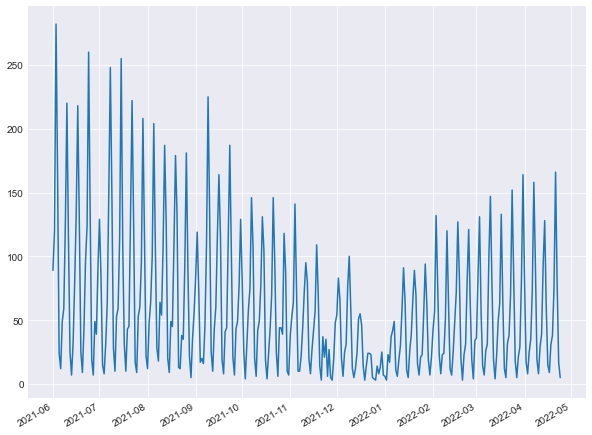

In [64]:
pd.to_datetime(listing_wa_lead["ACTIVE_DATE_C"]).value_counts().plot()

<AxesSubplot:>

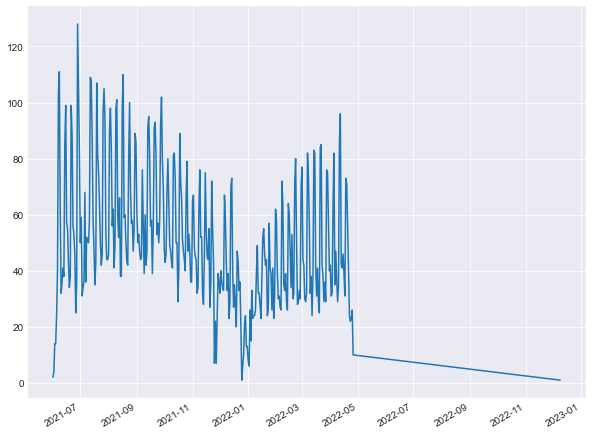

In [65]:
pd.to_datetime(listing_wa_lead["PURCHASE_CONTRACT_DATE_C"]).value_counts().plot()

<AxesSubplot:>

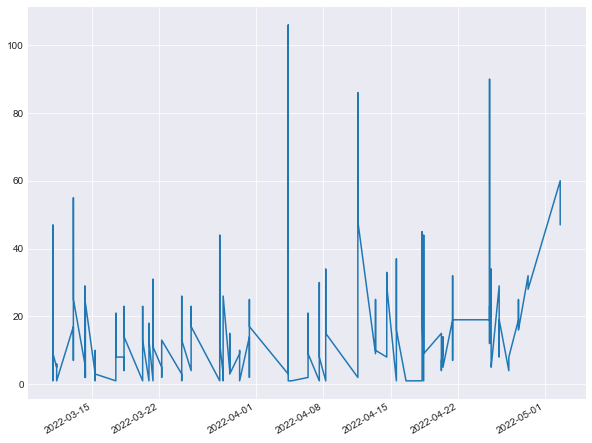

In [66]:
pd.to_datetime(listing_wa_lead["LAST_MODIFIED_DATE"]).value_counts().plot()

<AxesSubplot:>

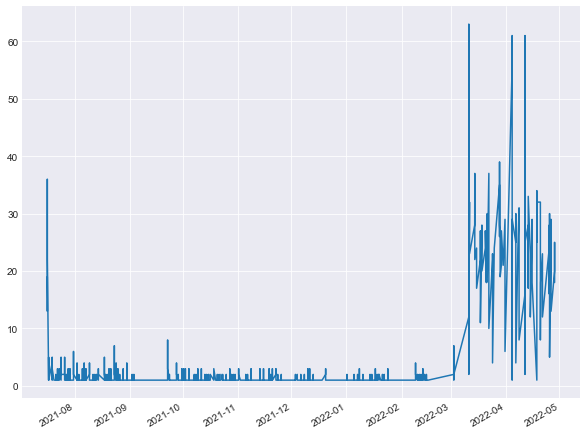

In [67]:
pd.to_datetime(listing_wa_lead["CREATED_DATE"]).value_counts().plot()

In [68]:
listing_wa_lead["CREATED_DATE"].describe()

/var/folders/3j/z2qkp3593qx624tzwlfnllkr0000gn/T/ipykernel_49252/549449280.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  listing_wa_lead["CREATED_DATE"].describe()


count                         19382
unique                         8572
top       2022-03-10 21:42:24-08:00
freq                             63
first     2021-07-16 13:28:14-07:00
last      2022-04-28 06:03:11-07:00
Name: CREATED_DATE, dtype: object

In [69]:
listing_wa_lead.shape

(19382, 45)

In [70]:
pd.to_datetime(listing_wa_lead["PURCHASE_CONTRACT_DATE_C"]).min()

Timestamp('2021-06-01 00:00:00')

In [71]:
pd.to_datetime(listing_wa_lead["ACTIVE_DATE_C"]).min()

Timestamp('2021-06-01 00:00:00')

In [72]:
listing_wa_lead_cutoff = listing_wa_lead[(pd.to_datetime(listing_wa_lead["ACTIVE_DATE_C"]).dt.date >= dt.date(2021,6,1))&(pd.to_datetime(listing_wa_lead["ACTIVE_DATE_C"]).dt.date < dt.date(2021,12,1))]

In [73]:
# listing_wa_lead_cutoff.to_csv("listing_wa_lead_cutoff.csv")

In [74]:
# ax = listing_wa_lead.groupby("LEAD_C")["LIST_PRICE_C"].sum().sort_values(ascending = False).head(50).plot(kind = "barh")
# ax.invert_yaxis()
# plt.show()

In [75]:
listing_wa_lead.dtypes

index                                                         int64
ID                                                           object
OWNER_ID                                                     object
IS_DELETED                                                     bool
NAME                                                         object
CREATED_DATE                    datetime64[ns, America/Los_Angeles]
CREATED_BY_ID                                                object
LAST_MODIFIED_DATE              datetime64[ns, America/Los_Angeles]
LAST_MODIFIED_BY_ID                                          object
SYSTEM_MODSTAMP                 datetime64[ns, America/Los_Angeles]
LAST_ACTIVITY_DATE                                           object
LAST_VIEWED_DATE                datetime64[ns, America/Los_Angeles]
LAST_REFERENCED_DATE            datetime64[ns, America/Los_Angeles]
ADDRESS_C                                                    object
CITY_C                                          

In [76]:
listing_wa_lead.columns

Index(['index', 'ID', 'OWNER_ID', 'IS_DELETED', 'NAME', 'CREATED_DATE',
       'CREATED_BY_ID', 'LAST_MODIFIED_DATE', 'LAST_MODIFIED_BY_ID',
       'SYSTEM_MODSTAMP', 'LAST_ACTIVITY_DATE', 'LAST_VIEWED_DATE',
       'LAST_REFERENCED_DATE', 'ADDRESS_C', 'CITY_C', 'LIST_AGENT_EMAIL_C',
       'LIST_AGENT_FULL_NAME_C', 'LIST_AGENT_PREFERRED_PHONE_C',
       'LIST_AGENT_STATE_LICENSE_C', 'LIST_OFFICE_EMAIL_C',
       'LIST_OFFICE_MLS_ID_C', 'LIST_OFFICE_NAME_C', 'LIST_OFFICE_PHONE_C',
       'LIST_PRICE_C', 'LISTING_AGENT_MLS_ID_C', 'LISTING_TERMS_C',
       'MLS_LISTING_NUMBER_C', 'MLS_STATUS_C', 'PARCEL_NUMBER_C',
       'POSTAL_CODE_PLUS_4_C', 'POSTAL_CODE_C', 'PREFERRED_TITLE_AND_ESCROW_C',
       'PRIVATE_REMARKS_C', 'PROPERTY_TYPE_C', 'PURCHASE_CONTRACT_DATE_C',
       'STANDARD_STATUS_C', 'STATE_OR_PROVINCE_C', 'UNPARSED_ADDRESS_C',
       'ZONING_DESCRIPTION_C', 'CONTACT_C', 'LEAD_C', 'MLS_BOARD_C',
       'LISTING_CONTRACT_DATE_C', 'ACTIVE_DATE_C', '_FIVETRAN_SYNCED'],
      dtype

In [77]:
### seems that ACTIVE_DATE_C is the listing date

In [78]:
listing_wa_lead["ACTIVE_DATE_C"].min()

datetime.date(2021, 6, 1)

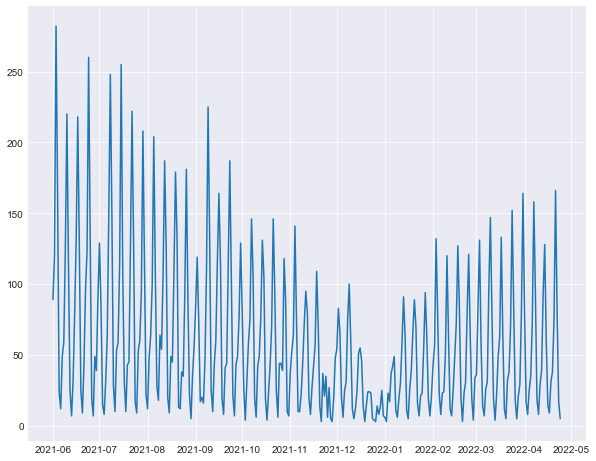

In [79]:
listing_wa_lead["ACTIVE_DATE_C"].value_counts().plot()
plt.show()

In [80]:
wa_lead_hist[wa_lead_hist["NEW_VALUE"] == "Committed"]["CREATED_DATE"].min()

Timestamp('2020-06-01 11:58:57-0700', tz='America/Los_Angeles')

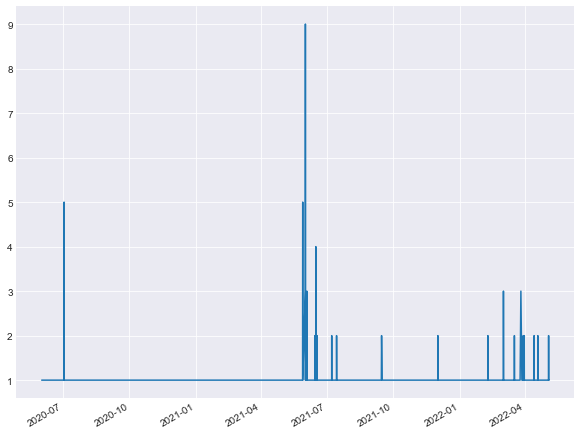

In [81]:
wa_lead_hist[wa_lead_hist["NEW_VALUE"] == "Committed"]["CREATED_DATE"].value_counts().plot()
plt.show()

In [82]:
wa_lead["CREATED_DATE"].min()

Timestamp('2018-08-07 12:53:19-0700', tz='America/Los_Angeles')

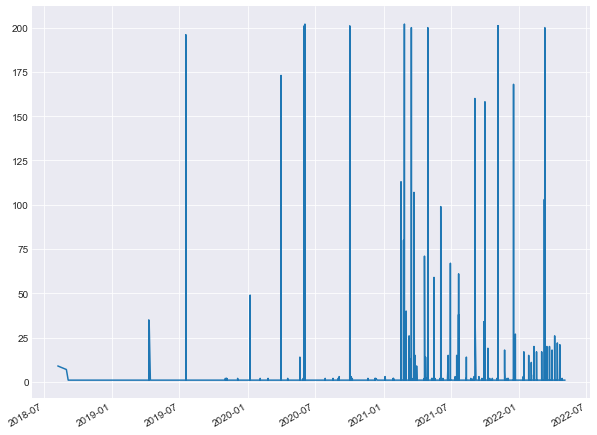

In [83]:
lead["CREATED_DATE"].value_counts().plot()
plt.show()

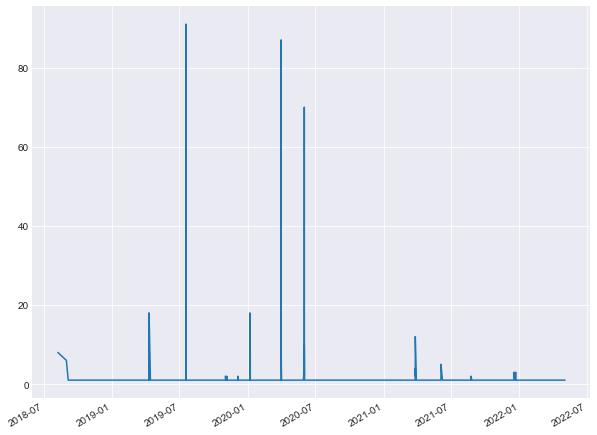

In [84]:
wa_lead["CREATED_DATE"].value_counts().plot()
plt.show()

In [85]:
# group by lead id, pick the latest status date, and use that date to aggregate listing information
last_status_dt = wa_lead_hist_status.loc[wa_lead_hist_status.groupby("LEAD_ID")["CREATED_DATE"].idxmax()][["LEAD_ID","CREATED_DATE"]]
last_status_dt.rename(columns = {"CREATED_DATE":"LAST_STATUS_DATE"}, inplace = True)
last_status_dt.head()

,LEAD_ID,LAST_STATUS_DATE
1351487,00Q1H000013ysKnUAI,2021-06-01 10:39:06-07:00
2097679,00Q1H000013ysKpUAI,2020-07-05 14:45:41-07:00
2532944,00Q1H000014wKDTUA2,2020-07-21 10:46:04-07:00
2106678,00Q1H000014wKDVUA2,2020-07-22 08:56:26-07:00
1128426,00Q1H000014xQRqUAM,2021-06-01 10:23:55-07:00


In [86]:
listing_wa_lead = listing_wa_lead.merge(last_status_dt, left_on= "LEAD_C", right_on= "LEAD_ID")
listing_wa_lead = listing_wa_lead[listing_wa_lead["CREATED_DATE"]<= listing_wa_lead["LAST_STATUS_DATE"]]


In [87]:
print(listing_wa_lead["LEAD_C"].nunique())
print(listing_wa_lead.shape)

714
(5992, 47)


In [88]:
listing_wa_lead.head(3)

,index,ID,OWNER_ID,IS_DELETED,NAME,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,LAST_ACTIVITY_DATE,LAST_VIEWED_DATE,LAST_REFERENCED_DATE,ADDRESS_C,CITY_C,LIST_AGENT_EMAIL_C,LIST_AGENT_FULL_NAME_C,LIST_AGENT_PREFERRED_PHONE_C,LIST_AGENT_STATE_LICENSE_C,LIST_OFFICE_EMAIL_C,LIST_OFFICE_MLS_ID_C,LIST_OFFICE_NAME_C,LIST_OFFICE_PHONE_C,LIST_PRICE_C,LISTING_AGENT_MLS_ID_C,LISTING_TERMS_C,MLS_LISTING_NUMBER_C,MLS_STATUS_C,PARCEL_NUMBER_C,POSTAL_CODE_PLUS_4_C,POSTAL_CODE_C,PREFERRED_TITLE_AND_ESCROW_C,PRIVATE_REMARKS_C,PROPERTY_TYPE_C,PURCHASE_CONTRACT_DATE_C,STANDARD_STATUS_C,STATE_OR_PROVINCE_C,UNPARSED_ADDRESS_C,ZONING_DESCRIPTION_C,CONTACT_C,LEAD_C,MLS_BOARD_C,LISTING_CONTRACT_DATE_C,ACTIVE_DATE_C,_FIVETRAN_SYNCED,LEAD_ID,LAST_STATUS_DATE
0,6,a021H00000NGC4hQAH,0051H00000BeVAmQAN,False,L-00031256,2021-07-31 07:33:40-07:00,0051H00000BeVAmQAN,2022-03-13 00:38:09-08:00,0058V00000C7vv8QAB,2022-03-13 00:38:09-08:00,None,NaT,NaT,"9943 181ST AVE N E, REDMOND, WA 98052, USA",Redmond,redmond@windermere.com,Shelley Elenbaas,206-999-9961,None,rdmtransactions@windermere.com,5581,Windermere Real Estate/East,425-883-0088,1375000.0,94132,"Cash Out,Conventional",1802562,Sold,2193340380,6903,98052,CW Escrow,Pls use showing time & follow covid rules. CW ...,Residential,2021-08-02,Sold,WA,None,R-5,None,00Q1H00001EwhqaUAB,NWMLS,None,2021-07-28,2022-03-13 07:42:01.686000-07:00,00Q1H00001EwhqaUAB,2021-08-16 12:32:29-07:00
8,25667,a021H00000NEOKGQA5,0051H00000BeVAmQAN,False,L-00035550,2021-08-13 07:32:03-07:00,0051H00000BeVAmQAN,2022-03-13 00:32:48-08:00,0058V00000C7vv8QAB,2022-03-13 00:32:48-08:00,None,NaT,NaT,"17562 149TH ST S E, MONROE, WA 98272, USA",Monroe,redmond@windermere.com,Shelley Elenbaas,206-999-9961,None,rdmtransactions@windermere.com,5581,Windermere Real Estate/East,425-883-0088,574950.0,94132,"Cash Out,Conventional,FHA",1819111,Sold,00847600003300,2684,98272,CW Escrow,No showings b4 12:00 pm on 8/11. Showings from...,Residential,2021-08-16,Sold,WA,None,R-4,None,00Q1H00001EwhqaUAB,NWMLS,None,2021-08-11,2022-03-13 00:41:20.141000-08:00,00Q1H00001EwhqaUAB,2021-08-16 12:32:29-07:00
9,26477,a021H00000NG4w8QAD,0051H00000BeVAmQAN,False,L-00014666,2021-07-16 13:29:42-07:00,0051H00000BeVAmQAN,2022-03-13 00:32:59-08:00,0058V00000C7vv8QAB,2022-03-13 00:32:59-08:00,None,NaT,NaT,"18024 32ND AVE S E, BOTHELL, WA 98012, USA",Bothell,redmond@windermere.com,Michelle Elenbaas,206-999-9961,None,rdmtransactions@windermere.com,5581,Windermere Real Estate/East,425-883-0088,985000.0,94132,"Cash,Conventional",1777012,Sold,00904000005100,9345,98012,CW Escrow,CHANGE FOR DEADLINE TO SUBMIT OFFERS -by 11:00...,Residential,2021-06-07,Sold,WA,None,COUNTY,None,00Q1H00001EwhqaUAB,NWMLS,None,2021-06-02,2022-03-13 00:41:21.156000-08:00,00Q1H00001EwhqaUAB,2021-08-16 12:32:29-07:00


In [89]:
# things that can be aggregate
# listing price: avg / sum
# STATE_OR_PROVINCE_C:  nunique
# PROPERTY_TYPE_C : nunique, mode
# CITY_C: nunique
# ID: nunique (number of listings)

### Salesforce Share wallet fields

- Total Transaction Count
- Total Sales
- Listing Count
- LS Sales
- BS Count
- BS Sales
- Preferred Title Co.
- Secondary Title Co.
- Preferred Escrow Co.
- Secondary Escrow Co.
- Preferred Title SOW
- Total Directed Title Transactions
- Preferred Escrow SOW
- Total Directed Escrow Transactions
- Average Close Price
- FA Directed Transations


In [90]:
# columns that in the Salesforce dataset
wallet_share_col = ["TOTAL_TRANSACTION_COUNT_C",
                    "TOTAL_SALES_C",
                    "TOTAL_LISTING_COUNT_C",
                    "LS_SALES_C",
                    "BS_COUNT_C",
                    "BS_SALES_C",
                    "PREFERRED_TITLE_COMPANY_C",
                    "SECONDARY_TITLE_CO_C",
                    "SECONDARY_ESCROW_CO_C",
                    # PREFERRED TITLE SOW NOT FOUND IN DATA
                    # TOTAL DIRECTED TITLE TRANSACTIONS NOT FOUND IN DATA
                    "PREFERRED_ESCROW_SOW_C",
                    "TOTAL_DIRECTED_ESCROW_TRANSACTIONS_C",
                    "AVERAGE_CLOSE_PRICE_C",
                    "FA_DIRECTED_TRANSACTIONS_C"
                    ]

In [91]:
#n_missing in overall leads
for col in wallet_share_col:
    num_empty = lead[col].isnull().sum()
    prop = num_empty / len(lead)
    print("{} Column: {:20} -- % Missing: {:.4f}".format("!" if prop > 0.3 else "",col,prop)) # try to align the dash to make the number aligned

! Column: TOTAL_TRANSACTION_COUNT_C -- % Missing: 0.9178
! Column: TOTAL_SALES_C        -- % Missing: 0.9973
! Column: TOTAL_LISTING_COUNT_C -- % Missing: 0.8405
! Column: LS_SALES_C           -- % Missing: 0.9972
! Column: BS_COUNT_C           -- % Missing: 0.8657
! Column: BS_SALES_C           -- % Missing: 0.9987
! Column: PREFERRED_TITLE_COMPANY_C -- % Missing: 0.9907
! Column: SECONDARY_TITLE_CO_C -- % Missing: 1.0000
! Column: SECONDARY_ESCROW_CO_C -- % Missing: 1.0000
! Column: PREFERRED_ESCROW_SOW_C -- % Missing: 0.9999
! Column: TOTAL_DIRECTED_ESCROW_TRANSACTIONS_C -- % Missing: 0.9999
! Column: AVERAGE_CLOSE_PRICE_C -- % Missing: 0.8439
! Column: FA_DIRECTED_TRANSACTIONS_C -- % Missing: 0.9999


In [92]:
# n_missing in wa_leads
for col in wallet_share_col:
    num_empty = wa_lead[col].isnull().sum()
    prop = num_empty / len(wa_lead)
    print("{} Column: {:20} -- % Missing: {:.4f}".format("!" if prop > 0.3 else "",col,prop)) # try to align the dash to make the number aligned

! Column: TOTAL_TRANSACTION_COUNT_C -- % Missing: 0.8789
! Column: TOTAL_SALES_C        -- % Missing: 0.9192
 Column: TOTAL_LISTING_COUNT_C -- % Missing: 0.2628
! Column: LS_SALES_C           -- % Missing: 0.9216
! Column: BS_COUNT_C           -- % Missing: 0.9899
! Column: BS_SALES_C           -- % Missing: 0.9970
! Column: PREFERRED_TITLE_COMPANY_C -- % Missing: 0.6751
! Column: SECONDARY_TITLE_CO_C -- % Missing: 0.9996
! Column: SECONDARY_ESCROW_CO_C -- % Missing: 1.0000
! Column: PREFERRED_ESCROW_SOW_C -- % Missing: 0.9999
! Column: TOTAL_DIRECTED_ESCROW_TRANSACTIONS_C -- % Missing: 0.9999
! Column: AVERAGE_CLOSE_PRICE_C -- % Missing: 0.4071
! Column: FA_DIRECTED_TRANSACTIONS_C -- % Missing: 0.9999


In [93]:
listing_wa_lead.groupby("LEAD_C").agg(
    LIST_PRICE_MEAN=pd.NamedAgg(column="LIST_PRICE_C", aggfunc="mean"),
    LIST_PRICE_SUM =pd.NamedAgg(column="LIST_PRICE_C", aggfunc="sum"),
    N_LISTING=pd.NamedAgg(column="ID", aggfunc="nunique"),
    N_CITY =pd.NamedAgg(column="CITY_C", aggfunc="nunique"),
    N_STATE = pd.NamedAgg(column="STATE_OR_PROVINCE_C", aggfunc="nunique"),
    N_PROP_TYPE = pd.NamedAgg(column="PROPERTY_TYPE_C", aggfunc="nunique"),

    )

,LIST_PRICE_MEAN,LIST_PRICE_SUM,N_LISTING,N_CITY,N_STATE,N_PROP_TYPE
LEAD_C,,,,,,
00Q1H000017xpmoUAA,484000.000000,968000.0,2,1,1,1
00Q1H0000180LLdUAM,825833.333333,4955000.0,6,2,1,1
00Q1H000018YExxUAG,664990.000000,664990.0,1,1,1,1
00Q1H000018aCDGUA2,640255.277778,11524595.0,18,7,1,2
00Q1H000018aHQxUAM,965571.428571,20277000.0,21,7,1,1
...,...,...,...,...,...,...
00Q1H00001FdQgKUAV,384500.000000,769000.0,2,1,1,1
00Q1H00001FdR3sUAF,380311.111111,6845600.0,18,7,1,2
00Q1H00001FdR3wUAF,143737.500000,1149900.0,8,2,1,2


#### Salesforce Task

In [94]:
query = "SELECT * FROM lake.salesforce.task WHERE WHO_ID IN (SELECT ID from lake.salesforce.lead WHERE (lower(STATE) LIKE 'wa%'))"
wa_task = cur.execute(query).fetch_pandas_all().reset_index()

In [95]:
wa_task["ACTIVITY_DATE"] = pd.to_datetime(wa_task["ACTIVITY_DATE"])

In [96]:
wa_task.head()

,index,ID,WHO_ID,WHAT_ID,WHO_COUNT,WHAT_COUNT,SUBJECT,ACTIVITY_DATE,STATUS,PRIORITY,IS_HIGH_PRIORITY,OWNER_ID,DESCRIPTION,TYPE,IS_DELETED,ACCOUNT_ID,IS_CLOSED,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,CALL_DURATION_IN_SECONDS,CALL_TYPE,CALL_DISPOSITION,CALL_OBJECT,REMINDER_DATE_TIME,IS_REMINDER_SET,RECURRENCE_ACTIVITY_ID,IS_RECURRENCE,RECURRENCE_START_DATE_ONLY,RECURRENCE_END_DATE_ONLY,RECURRENCE_TIME_ZONE_SID_KEY,RECURRENCE_TYPE,RECURRENCE_INTERVAL,RECURRENCE_DAY_OF_WEEK_MASK,RECURRENCE_DAY_OF_MONTH,RECURRENCE_INSTANCE,RECURRENCE_MONTH_OF_YEAR,RECURRENCE_REGENERATED_TYPE,TASK_SUBTYPE,COMPLETED_DATE_TIME,LEAD_C,CONTACT_C,SALES_LOFT_1_CALL_DISPOSITION_C,SALES_LOFT_1_CALL_SENTIMENT_C,CALL_RESULTS_C,AIRCALL_ANSWERED_BY_C,AIRCALL_CALL_RECORDING_C,AIRCALL_COUNTRY_C,AIRCALL_PHONE_NUMBER_C,AIRCALL_TRANSFERRED_TO_C,AIRCALL_WAITING_TIME_C,PURPOSE_C,SALES_CADENCE_C,SALES_LOFT_1_SALES_LOFT_CADENCE_NAME_C,SALES_LOFT_1_SALES_LOFT_CLICKED_COUNT_C,SALES_LOFT_1_SALES_LOFT_EMAIL_TEMPLATE_TITLE_C,ZOOM_APP_ADDITIONAL_EMAILS_C,ZOOM_APP_CUSTOMER_DURATION_OF_MEETING_C,ZOOM_APP_CUSTOMER_START_TIME_C,ZOOM_APP_CUSTOMER_TIME_ZONE_C,ZOOM_APP_ICS_SEQUENCE_C,ZOOM_APP_JOIN_BEFORE_HOST_C,ZOOM_APP_MAKE_IT_ZOOM_MEETING_C,ZOOM_APP_USE_PERSONAL_ZOOM_MEETING_ID_C,ZOOM_APP_ZOOM_CALL_LOG_C,ZOOM_APP_ZOOM_EVENT_C,SALES_LOFT_1_SALES_LOFT_REPLIES_COUNT_C,SALES_LOFT_1_SALES_LOFT_STEP_DAY_C,SALES_LOFT_1_SALES_LOFT_VIEW_COUNT_C,FSBO_CALL_RESULT_C,_FIVETRAN_SYNCED,HOW_WAS_YOUR_EXPERIENCE_WITH_ENDPOINT_C,WOULD_YOU_USE_ENDPOINT_ON_FUTURE_TRANSAC_C,DEMO_NO_SHOW_C,SALESLOFT_MEETING_NAME_C,SALESLOFT_MEETING_CANCELED_DATE_C,SALESLOFT_MEETING_TYPE_C,SALESLOFT_MEETING_DURATION_C,SALESLOFT_CALL_END_TIME_C,SALESLOFT_STEP_TYPE_C,SALESLOFT_MEETING_SOURCE_C,SALESLOFT_EMAIL_TEMPLATE_ID_C,SALESLOFT_CADENCE_ID_C,SALESLOFT_MEETING_RECORDING_URL_C,SALESLOFT_STEP_NAME_C,MEETING_NO_SHOW_C,SALESLOFT_CALL_TO_C,SALESLOFT_STEP_ID_C,SALESLOFT_BOUNCED_C,SALESLOFT_MEETING_START_TIME_C,SALESLOFT_MEETING_DATE_C,SALESLOFT_EMAIL_MESSAGE_ID_C,SALESLOFT_CALL_START_TIME_C,SALESLOFT_CADENCE_EXTERNAL_IDENTIFIER_C,SALESLOFT_MEETING_ASSIGNED_TO_C,SALESLOFT_MEETING_BOOKED_BY_C,IS_ARCHIVED
0,0,00T1H00004gkIwnUAE,00Q1H00001FdPGNUA3,None,1,0,Sent (Reply): Re: MA: 14018 32nd Ave NE Unit #...,2021-09-07,Completed,Normal,False,0051H00000AeGKuQAN,To: leiyurea@gmail.com\nCc: closing.wa@endpoin...,Email,False,None,True,2021-09-07 08:33:45-07:00,0051H00000AeGKuQAN,2021-09-07 08:33:45-07:00,0051H00000AeGKuQAN,2021-09-07 08:33:45-07:00,NaN,None,None,None,NaT,False,None,False,None,None,None,None,NaN,NaN,NaN,None,None,None,Email,2021-09-07 08:33:45-07:00,None,None,None,None,None,None,None,None,None,None,NaN,None,False,None,NaN,None,None,NaN,NaT,None,0.0,False,False,False,None,None,NaN,NaN,NaN,None,2021-09-07 17:12:52.086000-07:00,None,None,None,None,NaT,None,NaN,NaT,None,None,NaN,NaN,None,None,None,None,NaN,None,NaT,None,None,NaT,None,None,None,None
1,1,00T1H00004glunpUAA,00Q1H00001FdO2eUAF,None,1,0,Received: One more question--- 107718WA: 3219 ...,2021-09-11,Completed,Normal,False,0051H00000A36H7QAJ,"To: closing.wa@endpointclosing.com, pending@gr...",Email,False,None,True,2021-09-11 16:27:00-07:00,0051H00000A36H7QAJ,2021-09-11 16:27:00-07:00,0051H00000A36H7QAJ,2021-09-11 16:27:00-07:00,NaN,None,None,None,NaT,False,None,False,None,None,None,None,NaN,NaN,NaN,None,None,None,Email,2021-09-11 16:27:00-07:00,None,None,None,None,None,None,None,None,None,None,NaN,None,False,None,NaN,None,None,NaN,NaT,None,0.0,False,False,False,None,None,NaN,NaN,NaN,None,2021-09-11 19:42:07.508000-07:00,None,None,None,None,NaT,None,NaN,NaT,None,None,NaN,NaN,None,None,None,None,NaN,None,NaT,None,None,NaT,None,None,None,None
2,2,00T8V00004j7L32UAE,00Q1H00001EwhFmUAJ,None,1,0,Opened: Endpoint Title and Escrow,2021-10-02,Completed,Normal,False,0051H00000BQkufQAD,To: theriederssellhomes@gmail.com\nCc: \nBcc: ...,#N/A,False,None,True,2021-10-02 20:23:01-07:00,0051H00000BQkufQAD,2021-10-02 20:23:02-07:00,0051H00000B

In [97]:
wa_task_cutoff = wa_task[(wa_task["ACTIVITY_DATE"].dt.date >= dt.date(2021,6,1)) &(wa_task["ACTIVITY_DATE"].dt.date <= dt.date(2021,12,1))]

In [98]:
wa_task_cutoff = wa_task_cutoff.to_csv("wa_task_cutoff.csv")

In [99]:
#using 06/01/2021 as converted date, count the population, look at the activity 6 months later (<= 2020-11-30)
# to see if any status changes

In [100]:
june_lead_id = wa_task[wa_task["ACTIVITY_DATE"] <= pd.to_datetime("2020-06-01")]["WHO_ID"].to_list()

In [101]:
len(june_lead_id)

5250

In [102]:
# filter out leads who CREATED_DATE <= cutoff date start, summarize the status 
# using the id from those leads to subset tasks range from (cutoff date start, cutoff date end)
# summarize the attributes: 
# lead: most recent status, 
# lead_hist:status changes count
# task: total activity, total phone call, total email, other

In [103]:
cutoff_date_start = dt.date(2021,6,1)
cutoff_date_end = dt.date(2021,12,1)

In [104]:
cutoff_wa_lead = wa_lead[wa_lead["CREATED_DATE"].dt.date <= cutoff_date_start]

In [105]:
cutoff_wa_task = wa_task[(wa_task["WHO_ID"].isin(cutoff_wa_lead["ID"]))&(wa_task["ACTIVITY_DATE"].dt.date >= cutoff_date_start) & (wa_task["ACTIVITY_DATE"].dt.date < cutoff_date_end)]

In [106]:
# in wa_lead_hist_status, use cutoff_wa_lead["ID"], and cutoff_date_start, create the cutoff_status_start
# in wa_lead_hist_status, use cutoff_wa_lead["ID"], and cutoff_date_end, create the cutoff_status_end

In [107]:
cutoff_start_wa_lead_hist_status = wa_lead_hist_status[(wa_lead_hist_status["LEAD_ID"].isin(cutoff_wa_lead["ID"]))& (wa_lead_hist_status["CREATED_DATE"].dt.date <= cutoff_date_start)]
cutoff_status_start = cutoff_start_wa_lead_hist_status.loc[cutoff_start_wa_lead_hist_status.groupby("LEAD_ID")["CREATED_DATE"].idxmax(),["LEAD_ID","NEW_VALUE","CREATED_DATE"]]
cutoff_status_start

,LEAD_ID,NEW_VALUE,CREATED_DATE
1351487,00Q1H000013ysKnUAI,Disqualified,2021-06-01 10:39:06-07:00
2097679,00Q1H000013ysKpUAI,Disqualified,2020-07-05 14:45:41-07:00
2532944,00Q1H000014wKDTUA2,Committed,2020-07-21 10:46:04-07:00
2106678,00Q1H000014wKDVUA2,Committed,2020-07-22 08:56:26-07:00
1128426,00Q1H000014xQRqUAM,Committed,2021-06-01 10:23:55-07:00
...,...,...,...
2190430,00Q1H00001KFVkCUAX,Committed,2021-05-24 11:36:19-07:00
615358,00Q1H00001KFsGEUA1,Committed,2021-06-01 10:54:41-07:00
1397497,00Q1H00001Kb0EWUAZ,Committed,2021-06-01 10:40:27-07:00
593068,00Q1H00001Kb3m8UAB,Committed,2021-05-27 12:04:10-07:00


In [108]:
cutoff_end_wa_lead_hist_status = wa_lead_hist_status[(wa_lead_hist_status["LEAD_ID"].isin(cutoff_wa_lead["ID"]))& (wa_lead_hist_status["CREATED_DATE"].dt.date <= cutoff_date_end)]
cutoff_status_end = cutoff_end_wa_lead_hist_status.loc[cutoff_end_wa_lead_hist_status.groupby("LEAD_ID")["CREATED_DATE"].idxmax(),["LEAD_ID","NEW_VALUE","CREATED_DATE"]]
cutoff_status_end

,LEAD_ID,NEW_VALUE,CREATED_DATE
1351487,00Q1H000013ysKnUAI,Disqualified,2021-06-01 10:39:06-07:00
2097679,00Q1H000013ysKpUAI,Disqualified,2020-07-05 14:45:41-07:00
2532944,00Q1H000014wKDTUA2,Committed,2020-07-21 10:46:04-07:00
2106678,00Q1H000014wKDVUA2,Committed,2020-07-22 08:56:26-07:00
1128426,00Q1H000014xQRqUAM,Committed,2021-06-01 10:23:55-07:00
...,...,...,...
722579,00Q1H00001KayV8UAJ,Committed,2021-06-17 12:34:28-07:00
1397497,00Q1H00001Kb0EWUAZ,Committed,2021-06-01 10:40:27-07:00
593068,00Q1H00001Kb3m8UAB,Committed,2021-05-27 12:04:10-07:00
2060845,00Q1H00001Kb3mmUAB,Committed,2021-05-27 12:07:25-07:00


In [109]:
cutoff_status_start_end = cutoff_status_start.merge(cutoff_status_end, on = "LEAD_ID", suffixes=("_START","_END"))
cutoff_status_start_end

,LEAD_ID,NEW_VALUE_START,CREATED_DATE_START,NEW_VALUE_END,CREATED_DATE_END
0,00Q1H000013ysKnUAI,Disqualified,2021-06-01 10:39:06-07:00,Disqualified,2021-06-01 10:39:06-07:00
1,00Q1H000013ysKpUAI,Disqualified,2020-07-05 14:45:41-07:00,Disqualified,2020-07-05 14:45:41-07:00
2,00Q1H000014wKDTUA2,Committed,2020-07-21 10:46:04-07:00,Committed,2020-07-21 10:46:04-07:00
3,00Q1H000014wKDVUA2,Committed,2020-07-22 08:56:26-07:00,Committed,2020-07-22 08:56:26-07:00
4,00Q1H000014xQRqUAM,Committed,2021-06-01 10:23:55-07:00,Committed,2021-06-01 10:23:55-07:00
...,...,...,...,...,...
6005,00Q1H00001KFVkCUAX,Committed,2021-05-24 11:36:19-07:00,Committed,2021-05-24 11:36:19-07:00
6006,00Q1H00001KFsGEUA1,Committed,2021-06-01 10:54:41-07:00,Committed,2021-06-01 10:54:41-07:00
6007,00Q1H00001Kb0EWUAZ,Committed,2021-06-01 10:40:27-07:00,Committed,2021-06-01 10:40:27-07:00
6008,00Q1H00001Kb3m8UAB,Committed,2021-05-27 12:04:10-07:00,Committed,2021-05-27 12:04:10-07:00


In [110]:
cutoff_status_start_end[cutoff_status_start_end["CREATED_DATE_START"]!=cutoff_status_start_end["CREATED_DATE_END"]][["NEW_VALUE_START","NEW_VALUE_END"]].value_counts()

NEW_VALUE_START  NEW_VALUE_END
New              Committed        719
                 Working          163
                 Disqualified     120
Working          Committed         66
Disqualified     Committed         64
                 Disqualified      52
Working          Disqualified      27
Disqualified     Working            5
Demoed           Committed          2
New              New                2
Qualified        Committed          1
Working          Working            1
dtype: int64

In [111]:
cutoff_status_start_end[(cutoff_status_start_end["NEW_VALUE_START"] == "Disqualified")& (cutoff_status_start_end["NEW_VALUE_END"] == "Committed")]

,LEAD_ID,NEW_VALUE_START,CREATED_DATE_START,NEW_VALUE_END,CREATED_DATE_END
65,00Q1H000018alTfUAI,Disqualified,2020-07-05 14:34:13-07:00,Committed,2021-10-19 12:02:59-07:00
78,00Q1H00001AF8npUAD,Disqualified,2020-10-07 11:14:37-07:00,Committed,2021-06-17 12:38:44-07:00
252,00Q1H00001BL8c4UAD,Disqualified,2020-07-05 14:45:16-07:00,Committed,2021-06-17 12:25:02-07:00
334,00Q1H00001BL8ftUAD,Disqualified,2020-11-23 20:03:30-08:00,Committed,2021-07-14 13:33:27-07:00
396,00Q1H00001BL8iwUAD,Disqualified,2020-06-29 22:21:12-07:00,Committed,2021-08-24 12:05:40-07:00
412,00Q1H00001BL8jjUAD,Disqualified,2020-06-03 18:00:34-07:00,Committed,2021-07-14 20:02:43-07:00
548,00Q1H00001BwsWKUAZ,Disqualified,2020-05-29 10:29:17-07:00,Committed,2021-07-14 14:11:12-07:00
627,00Q1H00001C01LCUAZ,Disqualified,2020-06-30 14:19:34-07:00,Committed,2021-11-03 09:44:53-07:00
629,00Q1H00001C02GYUAZ,Disqualified,2020-09-24 14:35:12-07:00,Committed,2021-06-17 12:31:36-07:00
679,00Q1H00001CpGcWUAV,Disqualified,2020-06-30 13:02:05-07:00,Committed,2021-07-13 12:30:30-07:00


In [112]:
wa_task[wa_task["WHO_ID"].isin(cutoff_status_start_end[(cutoff_status_start_end["NEW_VALUE_START"] == "Disqualified") & (cutoff_status_start_end["NEW_VALUE_END"] == "Committed")]["LEAD_ID"])]

,index,ID,WHO_ID,WHAT_ID,WHO_COUNT,WHAT_COUNT,SUBJECT,ACTIVITY_DATE,STATUS,PRIORITY,IS_HIGH_PRIORITY,OWNER_ID,DESCRIPTION,TYPE,IS_DELETED,ACCOUNT_ID,IS_CLOSED,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,CALL_DURATION_IN_SECONDS,CALL_TYPE,CALL_DISPOSITION,CALL_OBJECT,REMINDER_DATE_TIME,IS_REMINDER_SET,RECURRENCE_ACTIVITY_ID,IS_RECURRENCE,RECURRENCE_START_DATE_ONLY,RECURRENCE_END_DATE_ONLY,RECURRENCE_TIME_ZONE_SID_KEY,RECURRENCE_TYPE,RECURRENCE_INTERVAL,RECURRENCE_DAY_OF_WEEK_MASK,RECURRENCE_DAY_OF_MONTH,RECURRENCE_INSTANCE,RECURRENCE_MONTH_OF_YEAR,RECURRENCE_REGENERATED_TYPE,TASK_SUBTYPE,COMPLETED_DATE_TIME,LEAD_C,CONTACT_C,SALES_LOFT_1_CALL_DISPOSITION_C,SALES_LOFT_1_CALL_SENTIMENT_C,CALL_RESULTS_C,AIRCALL_ANSWERED_BY_C,AIRCALL_CALL_RECORDING_C,AIRCALL_COUNTRY_C,AIRCALL_PHONE_NUMBER_C,AIRCALL_TRANSFERRED_TO_C,AIRCALL_WAITING_TIME_C,PURPOSE_C,SALES_CADENCE_C,SALES_LOFT_1_SALES_LOFT_CADENCE_NAME_C,SALES_LOFT_1_SALES_LOFT_CLICKED_COUNT_C,SALES_LOFT_1_SALES_LOFT_EMAIL_TEMPLATE_TITLE_C,ZOOM_APP_ADDITIONAL_EMAILS_C,ZOOM_APP_CUSTOMER_DURATION_OF_MEETING_C,ZOOM_APP_CUSTOMER_START_TIME_C,ZOOM_APP_CUSTOMER_TIME_ZONE_C,ZOOM_APP_ICS_SEQUENCE_C,ZOOM_APP_JOIN_BEFORE_HOST_C,ZOOM_APP_MAKE_IT_ZOOM_MEETING_C,ZOOM_APP_USE_PERSONAL_ZOOM_MEETING_ID_C,ZOOM_APP_ZOOM_CALL_LOG_C,ZOOM_APP_ZOOM_EVENT_C,SALES_LOFT_1_SALES_LOFT_REPLIES_COUNT_C,SALES_LOFT_1_SALES_LOFT_STEP_DAY_C,SALES_LOFT_1_SALES_LOFT_VIEW_COUNT_C,FSBO_CALL_RESULT_C,_FIVETRAN_SYNCED,HOW_WAS_YOUR_EXPERIENCE_WITH_ENDPOINT_C,WOULD_YOU_USE_ENDPOINT_ON_FUTURE_TRANSAC_C,DEMO_NO_SHOW_C,SALESLOFT_MEETING_NAME_C,SALESLOFT_MEETING_CANCELED_DATE_C,SALESLOFT_MEETING_TYPE_C,SALESLOFT_MEETING_DURATION_C,SALESLOFT_CALL_END_TIME_C,SALESLOFT_STEP_TYPE_C,SALESLOFT_MEETING_SOURCE_C,SALESLOFT_EMAIL_TEMPLATE_ID_C,SALESLOFT_CADENCE_ID_C,SALESLOFT_MEETING_RECORDING_URL_C,SALESLOFT_STEP_NAME_C,MEETING_NO_SHOW_C,SALESLOFT_CALL_TO_C,SALESLOFT_STEP_ID_C,SALESLOFT_BOUNCED_C,SALESLOFT_MEETING_START_TIME_C,SALESLOFT_MEETING_DATE_C,SALESLOFT_EMAIL_MESSAGE_ID_C,SALESLOFT_CALL_START_TIME_C,SALESLOFT_CADENCE_EXTERNAL_IDENTIFIER_C,SALESLOFT_MEETING_ASSIGNED_TO_C,SALESLOFT_MEETING_BOOKED_BY_C,IS_ARCHIVED


In [113]:
wa_task[(wa_task["WHO_ID"] == "00Q1H000018alTfUAI")& (wa_task["ACTIVITY_DATE"].dt.date >= cutoff_date_start)& (wa_task["ACTIVITY_DATE"].dt.date <= cutoff_date_end) ]

,index,ID,WHO_ID,WHAT_ID,WHO_COUNT,WHAT_COUNT,SUBJECT,ACTIVITY_DATE,STATUS,PRIORITY,IS_HIGH_PRIORITY,OWNER_ID,DESCRIPTION,TYPE,IS_DELETED,ACCOUNT_ID,IS_CLOSED,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,CALL_DURATION_IN_SECONDS,CALL_TYPE,CALL_DISPOSITION,CALL_OBJECT,REMINDER_DATE_TIME,IS_REMINDER_SET,RECURRENCE_ACTIVITY_ID,IS_RECURRENCE,RECURRENCE_START_DATE_ONLY,RECURRENCE_END_DATE_ONLY,RECURRENCE_TIME_ZONE_SID_KEY,RECURRENCE_TYPE,RECURRENCE_INTERVAL,RECURRENCE_DAY_OF_WEEK_MASK,RECURRENCE_DAY_OF_MONTH,RECURRENCE_INSTANCE,RECURRENCE_MONTH_OF_YEAR,RECURRENCE_REGENERATED_TYPE,TASK_SUBTYPE,COMPLETED_DATE_TIME,LEAD_C,CONTACT_C,SALES_LOFT_1_CALL_DISPOSITION_C,SALES_LOFT_1_CALL_SENTIMENT_C,CALL_RESULTS_C,AIRCALL_ANSWERED_BY_C,AIRCALL_CALL_RECORDING_C,AIRCALL_COUNTRY_C,AIRCALL_PHONE_NUMBER_C,AIRCALL_TRANSFERRED_TO_C,AIRCALL_WAITING_TIME_C,PURPOSE_C,SALES_CADENCE_C,SALES_LOFT_1_SALES_LOFT_CADENCE_NAME_C,SALES_LOFT_1_SALES_LOFT_CLICKED_COUNT_C,SALES_LOFT_1_SALES_LOFT_EMAIL_TEMPLATE_TITLE_C,ZOOM_APP_ADDITIONAL_EMAILS_C,ZOOM_APP_CUSTOMER_DURATION_OF_MEETING_C,ZOOM_APP_CUSTOMER_START_TIME_C,ZOOM_APP_CUSTOMER_TIME_ZONE_C,ZOOM_APP_ICS_SEQUENCE_C,ZOOM_APP_JOIN_BEFORE_HOST_C,ZOOM_APP_MAKE_IT_ZOOM_MEETING_C,ZOOM_APP_USE_PERSONAL_ZOOM_MEETING_ID_C,ZOOM_APP_ZOOM_CALL_LOG_C,ZOOM_APP_ZOOM_EVENT_C,SALES_LOFT_1_SALES_LOFT_REPLIES_COUNT_C,SALES_LOFT_1_SALES_LOFT_STEP_DAY_C,SALES_LOFT_1_SALES_LOFT_VIEW_COUNT_C,FSBO_CALL_RESULT_C,_FIVETRAN_SYNCED,HOW_WAS_YOUR_EXPERIENCE_WITH_ENDPOINT_C,WOULD_YOU_USE_ENDPOINT_ON_FUTURE_TRANSAC_C,DEMO_NO_SHOW_C,SALESLOFT_MEETING_NAME_C,SALESLOFT_MEETING_CANCELED_DATE_C,SALESLOFT_MEETING_TYPE_C,SALESLOFT_MEETING_DURATION_C,SALESLOFT_CALL_END_TIME_C,SALESLOFT_STEP_TYPE_C,SALESLOFT_MEETING_SOURCE_C,SALESLOFT_EMAIL_TEMPLATE_ID_C,SALESLOFT_CADENCE_ID_C,SALESLOFT_MEETING_RECORDING_URL_C,SALESLOFT_STEP_NAME_C,MEETING_NO_SHOW_C,SALESLOFT_CALL_TO_C,SALESLOFT_STEP_ID_C,SALESLOFT_BOUNCED_C,SALESLOFT_MEETING_START_TIME_C,SALESLOFT_MEETING_DATE_C,SALESLOFT_EMAIL_MESSAGE_ID_C,SALESLOFT_CALL_START_TIME_C,SALESLOFT_CADENCE_EXTERNAL_IDENTIFIER_C,SALESLOFT_MEETING_ASSIGNED_TO_C,SALESLOFT_MEETING_BOOKED_BY_C,IS_ARCHIVED


In [114]:
wa_lead_hist[wa_lead_hist["LEAD_ID"] == "00Q1H000018alTfUAI"]

,index,ID,IS_DELETED,LEAD_ID,CREATED_BY_ID,CREATED_DATE,FIELD,DATA_TYPE,OLD_VALUE,NEW_VALUE,_FIVETRAN_SYNCED
235225,3567,0178V00015QoPoFQAV,False,00Q1H000018alTfUAI,0051H00000BeVAmQAN,2021-10-19 12:02:59-07:00,Status,DynamicEnum,Disqualified,Committed,2021-10-19 13:42:52.901000-07:00
235237,3579,0178V00015QoPMmQAN,False,00Q1H000018alTfUAI,0051H00000BeVAmQAN,2021-10-19 12:02:58-07:00,leadConverted,Text,None,None,2021-10-19 13:42:52.910000-07:00
235275,3617,0178V00015QoPoGQAV,False,00Q1H000018alTfUAI,0051H00000BeVAmQAN,2021-10-19 12:02:59-07:00,Status,DynamicEnum,Committed,Disqualified,2021-10-19 13:42:52.901000-07:00
694734,27425,0171H0000xdiOaTQAU,False,00Q1H000018alTfUAI,0051H000008rwTGQAY,2020-06-29 22:40:29-07:00,Status,DynamicEnum,Working,Disqualified,2021-09-07 17:03:04.264000-07:00
720621,53312,0171H0000xk1AXpQAM,False,00Q1H000018alTfUAI,0051H000008rwTGQAY,2020-07-05 14:34:13-07:00,Status,DynamicEnum,Working,Disqualified,2021-09-07 17:03:03.987000-07:00
1069817,7588,0171H0000xk1AXqQAM,False,00Q1H000018alTfUAI,0051H000008rwTGQAY,2020-07-05 14:34:13-07:00,Disqualified_Reasons__c,DynamicEnum,None,DQ - First Am Loyal,2021-09-07 17:03:23.203000-07:00
1244672,27226,0171H0000xhm7NAQAY,False,00Q1H000018alTfUAI,0051H000008rwTGQAY,2020-07-02 11:57:53-07:00,Status,DynamicEnum,Disqualified,Working,2021-09-07 17:03:03.995000-07:00
2181896,18284,0171H0000xhm7NBQAY,False,00Q1H000018alTfUAI,0051H000008rwTGQAY,2020-07-02 11:57:53-07:00,Disqualified_Reasons__c,DynamicEnum,DQ - First Am Loyal,None,2021-09-07 17:03:23.213000-07:00
2646181,181794,0171H0000xdiOWgQAM,False,00Q1H000018alTfUAI,0051H000008rwTGQAY,2020-06-29 22:40:29-07:00,Disqualified_Reasons__c,DynamicEnum,None,DQ - First Am Loyal,2021-09-07 17:03:23.576000-07:00


In [115]:
wa_task[(wa_task["WHO_ID"] == "00Q1H00001KE579UAD")& (wa_task["ACTIVITY_DATE"].dt.date >= cutoff_date_start)& (wa_task["ACTIVITY_DATE"].dt.date <= cutoff_date_end) ]

,index,ID,WHO_ID,WHAT_ID,WHO_COUNT,WHAT_COUNT,SUBJECT,ACTIVITY_DATE,STATUS,PRIORITY,IS_HIGH_PRIORITY,OWNER_ID,DESCRIPTION,TYPE,IS_DELETED,ACCOUNT_ID,IS_CLOSED,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,CALL_DURATION_IN_SECONDS,CALL_TYPE,CALL_DISPOSITION,CALL_OBJECT,REMINDER_DATE_TIME,IS_REMINDER_SET,RECURRENCE_ACTIVITY_ID,IS_RECURRENCE,RECURRENCE_START_DATE_ONLY,RECURRENCE_END_DATE_ONLY,RECURRENCE_TIME_ZONE_SID_KEY,RECURRENCE_TYPE,RECURRENCE_INTERVAL,RECURRENCE_DAY_OF_WEEK_MASK,RECURRENCE_DAY_OF_MONTH,RECURRENCE_INSTANCE,RECURRENCE_MONTH_OF_YEAR,RECURRENCE_REGENERATED_TYPE,TASK_SUBTYPE,COMPLETED_DATE_TIME,LEAD_C,CONTACT_C,SALES_LOFT_1_CALL_DISPOSITION_C,SALES_LOFT_1_CALL_SENTIMENT_C,CALL_RESULTS_C,AIRCALL_ANSWERED_BY_C,AIRCALL_CALL_RECORDING_C,AIRCALL_COUNTRY_C,AIRCALL_PHONE_NUMBER_C,AIRCALL_TRANSFERRED_TO_C,AIRCALL_WAITING_TIME_C,PURPOSE_C,SALES_CADENCE_C,SALES_LOFT_1_SALES_LOFT_CADENCE_NAME_C,SALES_LOFT_1_SALES_LOFT_CLICKED_COUNT_C,SALES_LOFT_1_SALES_LOFT_EMAIL_TEMPLATE_TITLE_C,ZOOM_APP_ADDITIONAL_EMAILS_C,ZOOM_APP_CUSTOMER_DURATION_OF_MEETING_C,ZOOM_APP_CUSTOMER_START_TIME_C,ZOOM_APP_CUSTOMER_TIME_ZONE_C,ZOOM_APP_ICS_SEQUENCE_C,ZOOM_APP_JOIN_BEFORE_HOST_C,ZOOM_APP_MAKE_IT_ZOOM_MEETING_C,ZOOM_APP_USE_PERSONAL_ZOOM_MEETING_ID_C,ZOOM_APP_ZOOM_CALL_LOG_C,ZOOM_APP_ZOOM_EVENT_C,SALES_LOFT_1_SALES_LOFT_REPLIES_COUNT_C,SALES_LOFT_1_SALES_LOFT_STEP_DAY_C,SALES_LOFT_1_SALES_LOFT_VIEW_COUNT_C,FSBO_CALL_RESULT_C,_FIVETRAN_SYNCED,HOW_WAS_YOUR_EXPERIENCE_WITH_ENDPOINT_C,WOULD_YOU_USE_ENDPOINT_ON_FUTURE_TRANSAC_C,DEMO_NO_SHOW_C,SALESLOFT_MEETING_NAME_C,SALESLOFT_MEETING_CANCELED_DATE_C,SALESLOFT_MEETING_TYPE_C,SALESLOFT_MEETING_DURATION_C,SALESLOFT_CALL_END_TIME_C,SALESLOFT_STEP_TYPE_C,SALESLOFT_MEETING_SOURCE_C,SALESLOFT_EMAIL_TEMPLATE_ID_C,SALESLOFT_CADENCE_ID_C,SALESLOFT_MEETING_RECORDING_URL_C,SALESLOFT_STEP_NAME_C,MEETING_NO_SHOW_C,SALESLOFT_CALL_TO_C,SALESLOFT_STEP_ID_C,SALESLOFT_BOUNCED_C,SALESLOFT_MEETING_START_TIME_C,SALESLOFT_MEETING_DATE_C,SALESLOFT_EMAIL_MESSAGE_ID_C,SALESLOFT_CALL_START_TIME_C,SALESLOFT_CADENCE_EXTERNAL_IDENTIFIER_C,SALESLOFT_MEETING_ASSIGNED_TO_C,SALESLOFT_MEETING_BOOKED_BY_C,IS_ARCHIVED


In [116]:
wa_lead_hist[wa_lead_hist["LEAD_ID"] == "00Q1H00001KE579UAD"]

,index,ID,IS_DELETED,LEAD_ID,CREATED_BY_ID,CREATED_DATE,FIELD,DATA_TYPE,OLD_VALUE,NEW_VALUE,_FIVETRAN_SYNCED
648227,35852,0171H00013sfhBhQAI,False,00Q1H00001KE579UAD,0051H00000BeVAmQAN,2021-06-17 12:31:53-07:00,leadConverted,Text,None,None,2021-09-07 17:03:27.334000-07:00
1052696,19022,0171H00013sfhP3QAI,False,00Q1H00001KE579UAD,0051H00000BeVAmQAN,2021-06-17 12:31:55-07:00,Status,DynamicEnum,Committed,Disqualified,2021-09-07 17:03:01.977000-07:00
1165130,47982,0171H00013ZYxi8QAD,False,00Q1H00001KE579UAD,0051H00000AeGKuQAN,2021-05-28 15:33:41-07:00,Disqualified_Reasons__c,DynamicEnum,None,DQ - Nurture,2021-09-07 17:03:22.693000-07:00
1241795,24349,0171H00013DASbfQAH,False,00Q1H00001KE579UAD,0051H00000AeGKuQAN,2021-05-04 15:58:25-07:00,Last_Modified__c,DateOnly,None,2021-05-04,2021-09-07 17:03:33.728000-07:00
2102116,21624,0171H00013ZYxi9QAD,False,00Q1H00001KE579UAD,0051H00000AeGKuQAN,2021-05-28 15:33:41-07:00,Last_Modified__c,DateOnly,2021-05-04,2021-05-28,2021-09-07 17:03:31.575000-07:00
2103205,22713,0171H00013ZYxiAQAT,False,00Q1H00001KE579UAD,0051H00000AeGKuQAN,2021-05-28 15:33:41-07:00,Status,DynamicEnum,New,Disqualified,2021-09-07 17:03:02.415000-07:00
2178715,15103,0171H00013DASbeQAH,False,00Q1H00001KE579UAD,0051H00000AeGKuQAN,2021-05-04 15:58:25-07:00,created,Text,None,None,2021-09-07 17:04:40.506000-07:00
2179023,15411,0171H00013DASbgQAH,False,00Q1H00001KE579UAD,0051H00000AeGKuQAN,2021-05-04 15:58:25-07:00,MobilePhone,Phone,425-628-9841,(425) 628-9841,2021-09-07 17:03:55.548000-07:00
2642198,177811,0171H00013sfhBkQAI,False,00Q1H00001KE579UAD,0051H00000BeVAmQAN,2021-06-17 12:31:55-07:00,Status,DynamicEnum,Disqualified,Committed,2021-09-07 17:03:01.977000-07:00


In [117]:
wa_lead_hist_status_agg[wa_lead_hist_status_agg["LEAD_ID"].isin(cutoff_status_start_end[(cutoff_status_start_end["NEW_VALUE_START"] == "Disqualified")& (cutoff_status_start_end["NEW_VALUE_END"] == "Committed")]["LEAD_ID"])].head(20)

,LEAD_ID,VALUE_AGG,VALUE_AGG_CLEAN,VALUE_AGG_START,VALUE_AGG_END,COMMITTED_DATE_MIN,COMMITTED_DATE_MAX,DISQUALIFIED_DATE_MIN,DISQUALIFIED_DATE_MAX,WORKING_DATE_MIN,WORKING_DATE_MAX
85,00Q1H000018alTfUAI,"Working-Disqualified,Disqualified-Working,Work...","Working,Disqualified,Working,Disqualified,Comm...",Working,Disqualified,2021-10-19 12:02:59-07:00,2021-10-19 12:02:59-07:00,2020-06-29 22:40:29-07:00,2021-10-19 12:02:59-07:00,2020-07-02 11:57:53-07:00,2020-07-02 11:57:53-07:00
100,00Q1H00001AF8npUAD,"Working-New,New-Working,Working-Disqualified,D...","Working,New,Working,Disqualified,Committed,Dis...",Working,Disqualified,2021-06-17 12:38:44-07:00,2021-06-17 12:38:44-07:00,2020-10-07 11:14:37-07:00,2021-06-17 12:38:44-07:00,2020-09-18 10:22:09-07:00,2020-09-18 10:22:09-07:00
291,00Q1H00001BL8c4UAD,"Working-New,New-Disqualified,Disqualified-Comm...","Working,New,Disqualified,Committed,Disqualified",Working,Disqualified,2021-06-17 12:25:02-07:00,2021-06-17 12:25:02-07:00,2020-07-05 14:45:16-07:00,2021-06-17 12:25:02-07:00,NaT,NaT
378,00Q1H00001BL8ftUAD,"Working-Disqualified,Disqualified-Committed,Co...","Working,Disqualified,Committed,Disqualified",Working,Disqualified,2021-07-14 13:33:27-07:00,2021-07-14 13:33:27-07:00,2020-11-23 20:03:30-08:00,2021-07-14 13:33:27-07:00,NaT,NaT
444,00Q1H00001BL8iwUAD,"Working-New,New-Disqualified,Disqualified-Comm...","Working,New,Disqualified,Committed,Disqualified",Working,Disqualified,2021-08-24 12:05:40-07:00,2021-08-24 12:05:40-07:00,2020-06-29 22:21:12-07:00,2021-08-24 12:05:40-07:00,NaT,NaT
463,00Q1H00001BL8jjUAD,"Working-Disqualified,Working-Disqualified,Disq...","Working,Disqualified,Disqualified,Working,Work...",Working,Committed,2021-07-14 20:02:43-07:00,2021-07-14 20:02:43-07:00,2020-06-03 18:00:34-07:00,2021-07-14 11:26:20-07:00,2021-07-14 11:26:20-07:00,2021-07-14 11:27:46-07:00
618,00Q1H00001BwsWKUAZ,"Demoed-Disqualified,Disqualified-Committed","Demoed,Disqualified,Committed",Demoed,Committed,2021-07-14 14:11:12-07:00,2021-07-14 14:11:12-07:00,2020-05-29 10:29:17-07:00,2020-05-29 10:29:17-07:00,NaT,NaT
707,00Q1H00001C01LCUAZ,"Working-Disqualified,Disqualified-Committed","Working,Disqualified,Committed",Working,Committed,2021-11-03 09:44:53-07:00,2021-11-03 09:44:53-07:00,2020-06-30 14:19:34-07:00,2020-06-30 14:19:34-07:00,NaT,NaT
709,00Q1H00001C02GYUAZ,"Disqualified-Working,Working-New,New-Working,W...","Disqualified,Working,New,Working,Disqualified,...",Disqualified,Disqualified,2021-06-17 12:31:36-07:00,2021-06-17 12:31:36-07:00,2020-09-24 14:35:12-07:00,2021-06-17 12:31:36-07:00,2020-05-28 13:32:11-07:00,2020-09-18 11:45:19-07:00
768,00Q1H00001CpGcWUAV,"Committed-Disqualified,Disqualified-Committed","Committed,Disqualified,Committed",Committed,Committed,2021-07-13 12:30:30-07:00,2021-07-13 12:30:30-07:00,2020-06-30 13:02:05-07:00,2020-06-30 13:02:05-07:00,NaT,NaT


#### cutoff_task

In [118]:
wa_task.head()

,index,ID,WHO_ID,WHAT_ID,WHO_COUNT,WHAT_COUNT,SUBJECT,ACTIVITY_DATE,STATUS,PRIORITY,IS_HIGH_PRIORITY,OWNER_ID,DESCRIPTION,TYPE,IS_DELETED,ACCOUNT_ID,IS_CLOSED,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,CALL_DURATION_IN_SECONDS,CALL_TYPE,CALL_DISPOSITION,CALL_OBJECT,REMINDER_DATE_TIME,IS_REMINDER_SET,RECURRENCE_ACTIVITY_ID,IS_RECURRENCE,RECURRENCE_START_DATE_ONLY,RECURRENCE_END_DATE_ONLY,RECURRENCE_TIME_ZONE_SID_KEY,RECURRENCE_TYPE,RECURRENCE_INTERVAL,RECURRENCE_DAY_OF_WEEK_MASK,RECURRENCE_DAY_OF_MONTH,RECURRENCE_INSTANCE,RECURRENCE_MONTH_OF_YEAR,RECURRENCE_REGENERATED_TYPE,TASK_SUBTYPE,COMPLETED_DATE_TIME,LEAD_C,CONTACT_C,SALES_LOFT_1_CALL_DISPOSITION_C,SALES_LOFT_1_CALL_SENTIMENT_C,CALL_RESULTS_C,AIRCALL_ANSWERED_BY_C,AIRCALL_CALL_RECORDING_C,AIRCALL_COUNTRY_C,AIRCALL_PHONE_NUMBER_C,AIRCALL_TRANSFERRED_TO_C,AIRCALL_WAITING_TIME_C,PURPOSE_C,SALES_CADENCE_C,SALES_LOFT_1_SALES_LOFT_CADENCE_NAME_C,SALES_LOFT_1_SALES_LOFT_CLICKED_COUNT_C,SALES_LOFT_1_SALES_LOFT_EMAIL_TEMPLATE_TITLE_C,ZOOM_APP_ADDITIONAL_EMAILS_C,ZOOM_APP_CUSTOMER_DURATION_OF_MEETING_C,ZOOM_APP_CUSTOMER_START_TIME_C,ZOOM_APP_CUSTOMER_TIME_ZONE_C,ZOOM_APP_ICS_SEQUENCE_C,ZOOM_APP_JOIN_BEFORE_HOST_C,ZOOM_APP_MAKE_IT_ZOOM_MEETING_C,ZOOM_APP_USE_PERSONAL_ZOOM_MEETING_ID_C,ZOOM_APP_ZOOM_CALL_LOG_C,ZOOM_APP_ZOOM_EVENT_C,SALES_LOFT_1_SALES_LOFT_REPLIES_COUNT_C,SALES_LOFT_1_SALES_LOFT_STEP_DAY_C,SALES_LOFT_1_SALES_LOFT_VIEW_COUNT_C,FSBO_CALL_RESULT_C,_FIVETRAN_SYNCED,HOW_WAS_YOUR_EXPERIENCE_WITH_ENDPOINT_C,WOULD_YOU_USE_ENDPOINT_ON_FUTURE_TRANSAC_C,DEMO_NO_SHOW_C,SALESLOFT_MEETING_NAME_C,SALESLOFT_MEETING_CANCELED_DATE_C,SALESLOFT_MEETING_TYPE_C,SALESLOFT_MEETING_DURATION_C,SALESLOFT_CALL_END_TIME_C,SALESLOFT_STEP_TYPE_C,SALESLOFT_MEETING_SOURCE_C,SALESLOFT_EMAIL_TEMPLATE_ID_C,SALESLOFT_CADENCE_ID_C,SALESLOFT_MEETING_RECORDING_URL_C,SALESLOFT_STEP_NAME_C,MEETING_NO_SHOW_C,SALESLOFT_CALL_TO_C,SALESLOFT_STEP_ID_C,SALESLOFT_BOUNCED_C,SALESLOFT_MEETING_START_TIME_C,SALESLOFT_MEETING_DATE_C,SALESLOFT_EMAIL_MESSAGE_ID_C,SALESLOFT_CALL_START_TIME_C,SALESLOFT_CADENCE_EXTERNAL_IDENTIFIER_C,SALESLOFT_MEETING_ASSIGNED_TO_C,SALESLOFT_MEETING_BOOKED_BY_C,IS_ARCHIVED
0,0,00T1H00004gkIwnUAE,00Q1H00001FdPGNUA3,None,1,0,Sent (Reply): Re: MA: 14018 32nd Ave NE Unit #...,2021-09-07,Completed,Normal,False,0051H00000AeGKuQAN,To: leiyurea@gmail.com\nCc: closing.wa@endpoin...,Email,False,None,True,2021-09-07 08:33:45-07:00,0051H00000AeGKuQAN,2021-09-07 08:33:45-07:00,0051H00000AeGKuQAN,2021-09-07 08:33:45-07:00,NaN,None,None,None,NaT,False,None,False,None,None,None,None,NaN,NaN,NaN,None,None,None,Email,2021-09-07 08:33:45-07:00,None,None,None,None,None,None,None,None,None,None,NaN,None,False,None,NaN,None,None,NaN,NaT,None,0.0,False,False,False,None,None,NaN,NaN,NaN,None,2021-09-07 17:12:52.086000-07:00,None,None,None,None,NaT,None,NaN,NaT,None,None,NaN,NaN,None,None,None,None,NaN,None,NaT,None,None,NaT,None,None,None,None
1,1,00T1H00004glunpUAA,00Q1H00001FdO2eUAF,None,1,0,Received: One more question--- 107718WA: 3219 ...,2021-09-11,Completed,Normal,False,0051H00000A36H7QAJ,"To: closing.wa@endpointclosing.com, pending@gr...",Email,False,None,True,2021-09-11 16:27:00-07:00,0051H00000A36H7QAJ,2021-09-11 16:27:00-07:00,0051H00000A36H7QAJ,2021-09-11 16:27:00-07:00,NaN,None,None,None,NaT,False,None,False,None,None,None,None,NaN,NaN,NaN,None,None,None,Email,2021-09-11 16:27:00-07:00,None,None,None,None,None,None,None,None,None,None,NaN,None,False,None,NaN,None,None,NaN,NaT,None,0.0,False,False,False,None,None,NaN,NaN,NaN,None,2021-09-11 19:42:07.508000-07:00,None,None,None,None,NaT,None,NaN,NaT,None,None,NaN,NaN,None,None,None,None,NaN,None,NaT,None,None,NaT,None,None,None,None
2,2,00T8V00004j7L32UAE,00Q1H00001EwhFmUAJ,None,1,0,Opened: Endpoint Title and Escrow,2021-10-02,Completed,Normal,False,0051H00000BQkufQAD,To: theriederssellhomes@gmail.com\nCc: \nBcc: ...,#N/A,False,None,True,2021-10-02 20:23:01-07:00,0051H00000BQkufQAD,2021-10-02 20:23:02-07:00,0051H00000B

In [119]:
wa_task.groupby("WHO_ID")["TYPE"].nunique().to_frame()

,TYPE
WHO_ID,
00Q1H000013ysKgUAI,1
00Q1H000013ysKhUAI,0
00Q1H000013ysKkUAI,0
00Q1H000013ysKlUAI,0
00Q1H000013ysKpUAI,1
...,...
00Q8V00001NK9YVUA1,1
00Q8V00001NK9gyUAD,1
00Q8V00001NKECyUAP,1


In [120]:
wa_task[["TYPE","TASK_SUBTYPE"]].value_counts()

TYPE           TASK_SUBTYPE
Call           Call            9640
Email          Email           8234
#N/A           Email           2877
Call           Task             307
Intercom Chat  Task             102
Email          Task              28
Meeting        Email              4
Task           Task               1
dtype: int64

In [166]:
wa_task[wa_task["TYPE"] == "#N/A"]['ACTIVITY_DATE'].describe()

/var/folders/3j/z2qkp3593qx624tzwlfnllkr0000gn/T/ipykernel_49252/3974688990.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  wa_task[wa_task["TYPE"] == "#N/A"]['ACTIVITY_DATE'].describe()


count                    2877
unique                    466
top       2020-10-13 00:00:00
freq                      107
first     2019-11-20 00:00:00
last      2021-12-30 00:00:00
Name: ACTIVITY_DATE, dtype: object

In [121]:
wa_task[(wa_task["ACTIVITY_DATE"].dt.date >= cutoff_date_start) & (wa_task["ACTIVITY_DATE"].dt.date < cutoff_date_end)].groupby("WHO_ID")[["TYPE","TASK_SUBTYPE"]].value_counts()

WHO_ID              TYPE   TASK_SUBTYPE
00Q1H000013ysKgUAI  Email  Email           3
00Q1H000018Pm2EUAS  Call   Call            2
                    Email  Email           1
                    #N/A   Email           1
00Q1H000018aCHRUA2  Email  Email           1
                                          ..
00Q8V00001LBoc3UAD  Email  Email           1
00Q8V00001M69hJUAR  Call   Call            1
00Q8V00001M69iCUAR  Call   Call            2
                    Email  Email           1
00Q8V00001M6nJ1UAJ  Call   Call            1
Length: 2888, dtype: int64

### function for rollback the status of the lead

In [122]:
wa_lead.head()

,index,ID,IS_DELETED,MASTER_RECORD_ID,LAST_NAME,FIRST_NAME,SALUTATION,MIDDLE_NAME,SUFFIX,NAME,RECORD_TYPE_ID,TITLE,COMPANY,STREET,CITY,STATE,POSTAL_CODE,COUNTRY,LATITUDE,LONGITUDE,GEOCODE_ACCURACY,PHONE,MOBILE_PHONE,FAX,EMAIL,WEBSITE,PHOTO_URL,DESCRIPTION,LEAD_SOURCE,STATUS,INDUSTRY,RATING,ANNUAL_REVENUE,NUMBER_OF_EMPLOYEES,OWNER_ID,HAS_OPTED_OUT_OF_EMAIL,IS_CONVERTED,CONVERTED_DATE,CONVERTED_ACCOUNT_ID,CONVERTED_CONTACT_ID,CONVERTED_OPPORTUNITY_ID,IS_UNREAD_BY_OWNER,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,LAST_ACTIVITY_DATE,DO_NOT_CALL,HAS_OPTED_OUT_OF_FAX,LAST_VIEWED_DATE,LAST_REFERENCED_DATE,LAST_TRANSFER_DATE,JIGSAW,JIGSAW_CONTACT_ID,EMAIL_BOUNCED_REASON,EMAIL_BOUNCED_DATE,INDIVIDUAL_ID,POSTAL_CODE_C,MOST_RECENT_CAMPAIGN_C,ALTERNATE_EMAIL_C,APEX_PROCESSED_C,KNOCK_WEBHOOK_C,ALTERNATE_PHONE_C,TOTAL_SALES_C,BOOK_SIZE_SOW_PREFERRED_C,EMAIL_BOUNCED_C,EVENT_TYPE_C,IS_LEAD_C,AVERAGE_LIST_PRICE_C,FSBO_ADDRESS_C,FSBO_LISTING_PRICE_C,FIRST_TASK_DATE_C,FIRST_EVENT_DATE_C,BROKERAGE_1_C,TOTAL_TRANSACTION_COUNT_C,COUNTY_C,SALES_LOFT_1_MOST_RECENT_CADENCE_NAME_C,SALES_LOFT_1_MOST_RECENT_CADENCE_NEXT_STEP_DUE_DATE_C,SALES_LOFT_1_MOST_RECENT_LAST_COMPLETED_STEP_C,DISQUALIFIED_NOTES_C,FA_LOYAL_LEAD_C,LS_SALES_C,TOTAL_LISTING_COUNT_C,PREFERRED_PROVIDER_BY_LISTING_COUNT_C,PRODUCT_DEMO_DATE_C,PREFERRED_ESCROW_COMPANY_C,ROLE_C,APP_DOWNLOAD_DATE_C,PREFERRED_TITLE_COMPANY_C,AGENT_MLS_ID_C,ORDER_ENTRY_NOTES_C,LEVEL_VETTING_C,LICENSE_NO_C,PARDOT_REASSIGNMENT_C,AGENT_ROLE_C,LISTING_PRICE_C,TOTAL_MODUS_TRANSACTION_COUNT_C,DIGITAL_TE_USER_C,PI_NEEDS_SCORE_SYNCED_C,PI_PARDOT_LAST_SCORED_AT_C,PI_CAMPAIGN_C,PI_COMMENTS_C,PI_CONVERSION_DATE_C,PI_CONVERSION_OBJECT_NAME_C,PI_CONVERSION_OBJECT_TYPE_C,PI_CREATED_DATE_C,PI_FIRST_ACTIVITY_C,PI_FIRST_SEARCH_TERM_C,PI_FIRST_SEARCH_TYPE_C,PI_FIRST_TOUCH_URL_C,PI_GRADE_C,PI_LAST_ACTIVITY_C,PI_NOTES_C,PI_PARDOT_HARD_BOUNCED_C,PI_SCORE_C,PI_URL_C,PI_UTM_CAMPAIGN_C,PI_UTM_CONTENT_C,PI_UTM_MEDIUM_C,PI_UTM_SOURCE_C,PI_UTM_TERM_C,LAST_MODIFIED_C,PREFERRED_PLATFORM_C,AVERAGE_CLOSE_PRICE_C,AVERAGE_TRANSACTION_AMOUNT_C,BS_COUNT_C,DISQUALIFIED_REASONS_C,FA_DIRECTED_ESCROW_TRANSACTIONS_C,FA_DIRECTED_TRANSACTIONS_C,LEAD_NUMBER_C,LEAD_RANKING_C,MATRIX_UNIQUE_ID_C,MEAL_TRACKER_C,PMXAGENT_ID_C,PREFERRED_ESCROW_SOW_C,SECONDARY_ESCROW_CO_C,SECONDARY_TITLE_CO_C,BS_SALES_C,TOTAL_DIRECTED_ESCROW_TRANSACTIONS_C,CHECKBOX_C,NMLS_ID_C,REFERRER_C,PROPERTY_ADDRESS_C,REFERRAL_EMAIL_C,COMING_SOON_ADDRESS_C,KCA_C,_FIVETRAN_SYNCED,EMAIL_UNKNOWN_DELIVERABILITY_C,ACCOUNT_MANAGER_C,SALES_DEVELOPMENT_REP_C,RELATIONSHIP_MANAGER_C,WEB_LEAD_C,KNOCK_WEBHOOK_2021_C,DO_NOT_CONTACT_C,MOBILE_INDEXED_C,DEMO_SET_ON_C,DEMO_SCHEDULED_FOR_C,STATE_STD
452,325,00Q1H00001Ewgz0UAB,False,None,Peters,Alyson,None,None,None,Alyson Peters,0121H000000zyGvQAI,None,Real Estate Investment Svcs,7609 Steilacoom Blvd SW #300 A,Lakewood,WA,98498,None,NaN,NaN,None,None,(253) 468-9294,None,alysonp@reisinvest.com,None,/services/images/photo/00Q1H00001Ewgz0UAB,None,Digital TE User,Committed,None,None,NaN,NaN,0051H000008sMEFQA2,False,True,2020-10-15,0011H00001csXfYQAU,0031H00002O3PSoQAN,0061H00000nYMQcQAO,False,2020-03-30 15:59:19-07:00,0051H000008rwTGQAY,2020-10-15 13:49:06-07:00,0051H000008sMEFQA2,2022-03-22 16:19:12-07:00,None,False,False,NaT,NaT,2020-10-08,None,None,None,NaT,None,None,None,None,False,False,None,NaN,38.0,False,None,False,NaN,None,NaN,None,None,0011H00001csXfYQAU,NaN,None,None,None,NaN,None,None,NaN,13.0,NaN,None,None,None,None,None,26650,None,Level 1 - 10+ listings/yr,126616,False,None,NaN,NaN,False,None,NaT,None,None,NaT,None,None,NaT,NaT,None,None,None,None,NaT,None,None,NaN,None,None,None,None,None,None,2020-10-15,None,287159.0,NaN,NaN,None,NaN,NaN,None,None,None,NaN,214284,NaN,None,None,NaN,NaN,False,None,None,None,None,None,False,2022-03-22 19:41:06.072000-07:00,False,None,None,None,False,False,False,None,None,NaT,WA
454,327,00Q1H00001BNE4LUAX,False,None,Marsh,Carla,None,None,None,Carla Marsh,0121H000000zyGvQAI,None,

In [123]:
wa_lead_hist.head()

,index,ID,IS_DELETED,LEAD_ID,CREATED_BY_ID,CREATED_DATE,FIELD,DATA_TYPE,OLD_VALUE,NEW_VALUE,_FIVETRAN_SYNCED
11,11,0171H00014yGtEuQAK,False,00Q1H00001FdH2sUAF,0051H00000AeGKuQAN,2021-09-17 15:07:01-07:00,Last_Modified__c,DateOnly,2021-09-16,2021-09-17,2021-09-17 19:41:46.655000-07:00
44,44,0171H00014yH2kSQAS,False,00Q1H00001FdLKDUA3,0051H000008sMEFQA2,2021-09-17 17:05:01-07:00,Last_Modified__c,DateOnly,2021-09-13,2021-09-17,2021-09-17 19:41:46.650000-07:00
65,65,0171H00014yGZ6GQAW,False,00Q1H00001EwgcrUAB,0051H00000BQg3LQAT,2021-09-17 14:58:40-07:00,FA_Loyal_Lead__c,DynamicEnum,Yes,No,2021-09-17 19:41:46.662000-07:00
125,125,0171H00014yGkIxQAK,False,00Q1H00001Cq6gzUAB,0051H00000AeGKuQAN,2021-09-17 14:25:01-07:00,Last_Modified__c,DateOnly,2021-09-14,2021-09-17,2021-09-17 19:41:46.658000-07:00
138,138,0171H00014yGZ6HQAW,False,00Q1H00001EwgcrUAB,0051H00000BQg3LQAT,2021-09-17 14:58:40-07:00,FA_Loyal_Lead__c,DynamicEnum,No,Yes,2021-09-17 19:41:46.662000-07:00


In [124]:
wa_lead_hist[wa_lead_hist["LEAD_ID"] == "00Q1H00001EwgcrUAB"].loc[wa_lead_hist[wa_lead_hist["LEAD_ID"] == "00Q1H00001EwgcrUAB"].groupby('FIELD')['CREATED_DATE'].transform('min').eq(wa_lead_hist['CREATED_DATE'])].reset_index(drop=True).sort_values("CREATED_DATE")

,index,ID,IS_DELETED,LEAD_ID,CREATED_BY_ID,CREATED_DATE,FIELD,DATA_TYPE,OLD_VALUE,NEW_VALUE,_FIVETRAN_SYNCED
4,41579,0171H0000x5oBVeQAM,False,00Q1H00001EwgcrUAB,0051H000008rwTGQAY,2020-05-31 20:51:20-07:00,Owner,Text,Alex Tumarinson,Unassigned Lead,2021-09-07 17:02:59.015000-07:00
5,32688,0171H0000x5oBVfQAM,False,00Q1H00001EwgcrUAB,0051H000008rwTGQAY,2020-05-31 20:51:20-07:00,Owner,EntityId,0051H000008rwTGQAY,00G1H000004ldrdUAA,2021-09-07 17:02:59.015000-07:00
6,96874,0171H0000x5oBdtQAE,False,00Q1H00001EwgcrUAB,0051H000008rwTGQAY,2020-05-31 20:51:20-07:00,Status,DynamicEnum,New,Working,2021-09-07 17:03:15.008000-07:00
3,24043,0171H0000xdiOMbQAM,False,00Q1H00001EwgcrUAB,0051H000008rwTGQAY,2020-06-29 22:39:41-07:00,Disqualified_Reasons__c,DynamicEnum,None,DQ - First Am Loyal,2021-09-07 17:03:23.579000-07:00
7,136845,0171H0000xdiOMaQAM,False,00Q1H00001EwgcrUAB,0051H000008rwTGQAY,2020-06-29 22:39:41-07:00,FA_Loyal_Lead__c,DynamicEnum,None,Yes,2021-09-07 17:03:49.816000-07:00
2,419,0171H00014yGs7dQAC,False,00Q1H00001EwgcrUAB,0051H000008sMEFQA2,2021-09-17 14:58:10-07:00,Last_Modified__c,DateOnly,None,2021-09-17,2021-09-17 19:41:46.656000-07:00
0,302,0171H00014yGsP7QAK,False,00Q1H00001EwgcrUAB,0051H000008sMEFQA2,2021-09-17 15:00:21-07:00,MobilePhone,Phone,None,253-350-8682,2021-09-17 19:41:46.662000-07:00
1,347,0171H00014yGsP8QAK,False,00Q1H00001EwgcrUAB,0051H000008sMEFQA2,2021-09-17 15:00:21-07:00,MobilePhone,Phone,253-350-8682,(253) 350-8682,2021-09-17 19:41:46.662000-07:00


In [125]:
# test_lead = wa_lead_hist[wa_lead_hist["LEAD_ID"] == "00Q1H00001EwgcrUAB"].loc[wa_lead_hist[wa_lead_hist["LEAD_ID"] == "00Q1H00001EwgcrUAB"].groupby('FIELD')['CREATED_DATE'].transform('min').eq(wa_lead_hist['CREATED_DATE'])].reset_index(drop=True).sort_values("CREATED_DATE")

In [126]:
# lead_hist[lead_hist["FIELD"] == "Owner"].sort_values("CREATED_DATE")

In [127]:
# ownerAssignment with EntityId type equals to OWNER_ID
lead[lead["OWNER_ID"].isin(lead_hist[(lead_hist["FIELD"] == "ownerAssignment") & (lead_hist["DATA_TYPE"] == "EntityId")]["OLD_VALUE"].unique())].head().shape

(5, 159)

In [128]:
for field in lead_hist["FIELD"].unique():
    if field.upper() in wa_lead.columns:
        # print(field,": pass")
        pass
    elif field.upper().replace("__","_") in wa_lead.columns:
        # print(field, ": pass with replacing _")
        pass
    else:
        print("!",field,": not pass")

! created : not pass
! MobilePhone : not pass
! leadConverted : not pass
! LeadSource : not pass
! Owner : not pass
! Brokerage1__c : not pass
! leadMerged : not pass
! HasOptedOutOfEmail : not pass
! ownerAssignment : not pass


In [129]:
# leadConvertted, created, leadMerged:  field has ineffective value changes (None to None) so that it's excluded
# Owner: Owner can't be found in lead columns
# ownerAssignment: need a extra filter to specify DATATYPE ==EntityId

# function to standardize the field name
def field_std(x:str) -> str:

    field_replace_dict = {"MobilePhone":"MOBILE_PHONE",
                    "LeadSource":"LEAD_SOURCE", 
                    "Brokerage1__c": "BROKERAGE_1_C",
                    "ownerAssignment": "OWNER_ID",
                    "HasOptedOutOfEmail":"HAS_OPTED_OUT_OF_EMAIL"}

    for key in field_replace_dict.keys():
        if x == key:
            x = field_replace_dict[key]
            
    x = x.upper()
    x = x.replace("__","_")
    
    return x

In [130]:
# lead_hist.sample(n =5)

In [131]:
test_lead_hist2= lead_hist[lead_hist["LEAD_ID"] == "00Q1H00001GSiupUAD"]
test_lead_hist2.head()

,index,ID,IS_DELETED,LEAD_ID,CREATED_BY_ID,CREATED_DATE,FIELD,DATA_TYPE,OLD_VALUE,NEW_VALUE,_FIVETRAN_SYNCED
387,387,0171H00014yGucnQAC,False,00Q1H00001GSiupUAD,0051H00000BeZYAQA3,2021-09-17 15:20:36-07:00,Last_Modified__c,DateOnly,2021-09-15,2021-09-17,2021-09-17 19:41:46.653000-07:00
17253,4341,0178V00015tdxNiQAI,False,00Q1H00001GSiupUAD,0051H00000BeZYAQA3,2021-11-18 11:04:29-08:00,Last_Modified__c,DateOnly,2021-10-15,2021-11-18,2021-11-18 12:44:13.127000-08:00
49107,23272,0178V000175W9tzQAC,False,00Q1H00001GSiupUAD,0051H00000BeZYAQA3,2022-02-07 15:49:16-08:00,Phone,Phone,(602) 329-1918,(888) 897-7821,2022-02-07 18:40:53.254000-08:00
49171,23336,0178V000175W9txQAC,False,00Q1H00001GSiupUAD,0051H00000BeZYAQA3,2022-02-07 15:49:16-08:00,Brokerage1__c,EntityId,0011H00002AJuj4QAD,0011H00002AJjMcQAL,2022-02-07 18:40:53.254000-08:00
49343,23508,0178V000175W9tyQAC,False,00Q1H00001GSiupUAD,0051H00000BeZYAQA3,2022-02-07 15:49:16-08:00,Level_Vetting__c,DynamicEnum,Level 2 - 4+ listings/yr,Level 1 - 10+ listings/yr,2022-02-07 18:40:53.254000-08:00


In [132]:
test_lead2 = lead[lead["ID"] == "00Q1H00001GSiupUAD"]
test_lead2

,index,ID,IS_DELETED,MASTER_RECORD_ID,LAST_NAME,FIRST_NAME,SALUTATION,MIDDLE_NAME,SUFFIX,NAME,RECORD_TYPE_ID,TITLE,COMPANY,STREET,CITY,STATE,POSTAL_CODE,COUNTRY,LATITUDE,LONGITUDE,GEOCODE_ACCURACY,PHONE,MOBILE_PHONE,FAX,EMAIL,WEBSITE,PHOTO_URL,DESCRIPTION,LEAD_SOURCE,STATUS,INDUSTRY,RATING,ANNUAL_REVENUE,NUMBER_OF_EMPLOYEES,OWNER_ID,HAS_OPTED_OUT_OF_EMAIL,IS_CONVERTED,CONVERTED_DATE,CONVERTED_ACCOUNT_ID,CONVERTED_CONTACT_ID,CONVERTED_OPPORTUNITY_ID,IS_UNREAD_BY_OWNER,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,LAST_ACTIVITY_DATE,DO_NOT_CALL,HAS_OPTED_OUT_OF_FAX,LAST_VIEWED_DATE,LAST_REFERENCED_DATE,LAST_TRANSFER_DATE,JIGSAW,JIGSAW_CONTACT_ID,EMAIL_BOUNCED_REASON,EMAIL_BOUNCED_DATE,INDIVIDUAL_ID,POSTAL_CODE_C,MOST_RECENT_CAMPAIGN_C,ALTERNATE_EMAIL_C,APEX_PROCESSED_C,KNOCK_WEBHOOK_C,ALTERNATE_PHONE_C,TOTAL_SALES_C,BOOK_SIZE_SOW_PREFERRED_C,EMAIL_BOUNCED_C,EVENT_TYPE_C,IS_LEAD_C,AVERAGE_LIST_PRICE_C,FSBO_ADDRESS_C,FSBO_LISTING_PRICE_C,FIRST_TASK_DATE_C,FIRST_EVENT_DATE_C,BROKERAGE_1_C,TOTAL_TRANSACTION_COUNT_C,COUNTY_C,SALES_LOFT_1_MOST_RECENT_CADENCE_NAME_C,SALES_LOFT_1_MOST_RECENT_CADENCE_NEXT_STEP_DUE_DATE_C,SALES_LOFT_1_MOST_RECENT_LAST_COMPLETED_STEP_C,DISQUALIFIED_NOTES_C,FA_LOYAL_LEAD_C,LS_SALES_C,TOTAL_LISTING_COUNT_C,PREFERRED_PROVIDER_BY_LISTING_COUNT_C,PRODUCT_DEMO_DATE_C,PREFERRED_ESCROW_COMPANY_C,ROLE_C,APP_DOWNLOAD_DATE_C,PREFERRED_TITLE_COMPANY_C,AGENT_MLS_ID_C,ORDER_ENTRY_NOTES_C,LEVEL_VETTING_C,LICENSE_NO_C,PARDOT_REASSIGNMENT_C,AGENT_ROLE_C,LISTING_PRICE_C,TOTAL_MODUS_TRANSACTION_COUNT_C,DIGITAL_TE_USER_C,PI_NEEDS_SCORE_SYNCED_C,PI_PARDOT_LAST_SCORED_AT_C,PI_CAMPAIGN_C,PI_COMMENTS_C,PI_CONVERSION_DATE_C,PI_CONVERSION_OBJECT_NAME_C,PI_CONVERSION_OBJECT_TYPE_C,PI_CREATED_DATE_C,PI_FIRST_ACTIVITY_C,PI_FIRST_SEARCH_TERM_C,PI_FIRST_SEARCH_TYPE_C,PI_FIRST_TOUCH_URL_C,PI_GRADE_C,PI_LAST_ACTIVITY_C,PI_NOTES_C,PI_PARDOT_HARD_BOUNCED_C,PI_SCORE_C,PI_URL_C,PI_UTM_CAMPAIGN_C,PI_UTM_CONTENT_C,PI_UTM_MEDIUM_C,PI_UTM_SOURCE_C,PI_UTM_TERM_C,LAST_MODIFIED_C,PREFERRED_PLATFORM_C,AVERAGE_CLOSE_PRICE_C,AVERAGE_TRANSACTION_AMOUNT_C,BS_COUNT_C,DISQUALIFIED_REASONS_C,FA_DIRECTED_ESCROW_TRANSACTIONS_C,FA_DIRECTED_TRANSACTIONS_C,LEAD_NUMBER_C,LEAD_RANKING_C,MATRIX_UNIQUE_ID_C,MEAL_TRACKER_C,PMXAGENT_ID_C,PREFERRED_ESCROW_SOW_C,SECONDARY_ESCROW_CO_C,SECONDARY_TITLE_CO_C,BS_SALES_C,TOTAL_DIRECTED_ESCROW_TRANSACTIONS_C,CHECKBOX_C,NMLS_ID_C,REFERRER_C,PROPERTY_ADDRESS_C,REFERRAL_EMAIL_C,COMING_SOON_ADDRESS_C,KCA_C,_FIVETRAN_SYNCED,EMAIL_UNKNOWN_DELIVERABILITY_C,ACCOUNT_MANAGER_C,SALES_DEVELOPMENT_REP_C,RELATIONSHIP_MANAGER_C,WEB_LEAD_C,KNOCK_WEBHOOK_2021_C,DO_NOT_CONTACT_C,MOBILE_INDEXED_C,DEMO_SET_ON_C,DEMO_SCHEDULED_FOR_C,STATE_STD
600583,9773,00Q1H00001GSiupUAD,False,None,Lucas,Tina,None,R,None,Tina R Lucas,0121H000000zyGvQAI,None,Jason Mitchell Real Estate,8360 E. Raintree Dr 120,Scottsdale,AZ,85260,None,NaN,NaN,None,(623) 242-9459,(602) 434-8086,None,tinalazrealtor@gmail.com,None,/services/images/photo/00Q1H00001GSiupUAD,None,Cold Account Creation,Working,None,None,NaN,NaN,00G1H000004ldrdUAA,False,False,None,None,None,None,True,2020-10-01 17:22:14-07:00,0051H000008rwTGQAY,2022-04-25 10:33:11-07:00,0051H00000BeZYAQA3,2022-04-25 10:33:11-07:00,2022-04-25,False,False,NaT,NaT,2022-03-16,None,None,None,NaT,None,None,7018V000000HFNxQAO,None,False,False,None,NaN,NaN,False,None,True,640000.0,None,NaN,2021-09-14,None,0011H00002AJjLGQA1,7.0,Maricopa,None,None,NaN,None,None,NaN,1.0,NaN,None,None,Agent,None,None,2.01601E+24,None,Level 1 - 10+ listings/yr,SA660683000,False,Salesperson,480000.0,NaN,False,None,NaT,None,None,NaT,None,None,NaT,NaT,None,None,None,None,NaT,None,None,NaN,None,None,None,None,None,None,2021-11-18,None,0.0,NaN,6.0,None,NaN,NaN,239048,None,None,NaN,361874,NaN,None,None,NaN,NaN,False,None,None,None,None,4518 S WILLOW DR,False,2022-04-25 11:40:56.496000-07:00,False,None,None,None,False,False,False,16024348086,None,NaT,AZ


In [133]:
test_lead_hist2.sort_values("CREATED_DATE")

,index,ID,IS_DELETED,LEAD_ID,CREATED_BY_ID,CREATED_DATE,FIELD,DATA_TYPE,OLD_VALUE,NEW_VALUE,_FIVETRAN_SYNCED
2244796,81184,0171H0000zRLKz2QAH,False,00Q1H00001GSiupUAD,0051H000008rwTGQAY,2020-10-01 17:22:14-07:00,created,Text,None,None,2021-09-07 17:05:13.687000-07:00
1135533,18385,0171H0000zRLL2xQAH,False,00Q1H00001GSiupUAD,0051H000008rwTGQAY,2020-10-01 17:22:14-07:00,MobilePhone,Phone,480-725-0127,(480) 725-0127,2021-09-07 17:04:35.597000-07:00
2072256,6065,0171H0000zRLL2wQAH,False,00Q1H00001GSiupUAD,0051H000008rwTGQAY,2020-10-01 17:22:14-07:00,Phone,Phone,None,(602) 329-1918,2021-09-07 17:06:12.507000-07:00
1151158,34010,0171H00014TbrkNQAR,False,00Q1H00001GSiupUAD,0051H000008sHbOQAU,2021-08-09 11:10:35-07:00,MobilePhone,Phone,(480) 725-0127,(602) 434-8086,2021-09-07 17:03:54.608000-07:00
233117,1459,0171H00014vrUUzQAM,False,00Q1H00001GSiupUAD,0051H000008sHbOQAU,2021-09-14 13:22:28-07:00,Owner,Text,Unassigned Lead,Tiffany Klem,2021-09-14 13:42:29.060000-07:00
232089,431,0171H00014vrUV2QAM,False,00Q1H00001GSiupUAD,0051H000008sHbOQAU,2021-09-14 13:22:28-07:00,Coming_Soon_Address__c,Text,None,4518 S WILLOW DR,2021-09-14 13:42:29.076000-07:00
231745,87,0171H00014vrUV0QAM,False,00Q1H00001GSiupUAD,0051H000008sHbOQAU,2021-09-14 13:22:28-07:00,Owner,EntityId,00G1H000004ldrdUAA,0051H00000BeZYAQA3,2021-09-14 13:42:29.060000-07:00
232548,890,0171H00014vrUV1QAM,False,00Q1H00001GSiupUAD,0051H000008sHbOQAU,2021-09-14 13:22:28-07:00,Listing_Price__c,Currency,None,480000,2021-09-14 13:42:29.084000-07:00
233364,1706,0171H00014vs0AmQAI,False,00Q1H00001GSiupUAD,0051H00000BeZYAQA3,2021-09-14 15:08:24-07:00,Last_Modified__c,DateOnly,None,2021-09-14,2021-09-14 19:41:49.086000-07:00
1007554,86,0171H00014vu0tpQAA,False,00Q1H00001GSiupUAD,0051H00000BeZYAQA3,2021-09-15 09:49:53-07:00,Last_Modified__c,DateOnly,2021-09-14,2021-09-15,2021-09-15 13:42:15.880000-07:00


In [134]:
# rollback function
# to rollback the status of the lead status, using the lead_hist, changing the value at the 'lead' dataset

# steps:
# set the cutoff date: cutoff date start, cutoff date end
# forward search the lead_hist, using lead_id and the lead_hist in range cutoff date, find the earlist change of each type of changes, and extract the old_value, replace the value on related columns
# return the dataset

def rollback_lead(input_lead_df:pd.DataFrame, 
                    lead_hist_df:pd.DataFrame, 
                    cutoff_date_start:dt.date, 
                    cutoff_date_end:dt.date) -> pd.DataFrame:
    
    #subset the data using lead id and cutoff dates
    subset_hist_df = lead_hist_df[(lead_hist_df["LEAD_ID"].isin(input_lead_df["ID"])) & (lead_hist_df["CREATED_DATE"].dt.date >= cutoff_date_start) & (lead_hist_df["CREATED_DATE"].dt.date <= cutoff_date_end)]

    # drop rows that contains fields which does not refer back to lead dataset
    filter_values = ["leadConvertted","created","leadMerged","Owner"]
    subset_hist_df = subset_hist_df[~subset_hist_df["FIELD"].isin(filter_values)]
    # ownerAssignment: need a extra filter to drop DATATYPE ==EntityId
    subset_hist_df = subset_hist_df[~(((subset_hist_df["FIELD"] == "Owner") | (subset_hist_df["FIELD"] == "ownerAssignment") )& (subset_hist_df["DATA_TYPE"] == "EntityId"))]

    # apply the field standardization function
    subset_hist_df["FIELD_STD"] = subset_hist_df["FIELD"].apply(field_std)

    # create a dataframe for output
    output_df = pd.DataFrame()

    # need to check cases with same fields
    for id in input_lead_df["ID"]:
        # extract the lead hist of the certain id
        id_subset = subset_hist_df[subset_hist_df["LEAD_ID"] == id]
        # filter only the first changes, by kind of fields
        id_subset = id_subset.loc[id_subset.groupby("FIELD_STD")["CREATED_DATE"].idxmin()]
        # create the dictionary to replace
        replace_dict = dict(zip(id_subset["FIELD_STD"],id_subset["OLD_VALUE"]))
        # pullout the id realted row for replacement
        lead_id_row = input_lead_df[input_lead_df["ID"] == id]
        # extract id index
        id_idx = lead_id_row.index
        # convert id row to dictonary
        lead_id_dict = lead_id_row.to_dict("index")[id_idx.values[0]]
        # use replace dict to update
        lead_id_dict.update(replace_dict)
        # transform back to dataframe and append to output dataframe
        output_df = pd.concat([output_df, pd.DataFrame(lead_id_dict, index = id_idx)])

    return output_df


In [135]:
rollback_wa_lead = rollback_lead(wa_lead,wa_lead_hist,cutoff_date_start,cutoff_date_end)

In [136]:
# rollback_wa_lead.to_csv("rollback_wa_lead.csv")

#### MLS listings

In [137]:
query = "SELECT * FROM LAKE.PROPMIX.LISTING_DETAILS_WASHINGTON_VW"
wa_pm_listing = cur.execute(query).fetch_pandas_all().reset_index()

In [138]:
[i for i in wa_pm_listing.columns if "DATE" in i]

['LOAD_DATE',
 'EXTRACT_DATE',
 'AVAILABILITYDATE',
 'CLOSEDATE',
 'CONTINGENTDATE',
 'CONTRACTSTATUSCHANGEDATE',
 'LISTINGCONTRACTDATE',
 'OFFMARKETDATE',
 'ONMARKETDATE',
 'PURCHASECONTRACTDATE']

In [139]:
# LISTINGCONTRACTDATE is the date for the listing 
wa_pm_listing[[i for i in wa_pm_listing.columns if "DATE" in i]]


,LOAD_DATE,EXTRACT_DATE,AVAILABILITYDATE,CLOSEDATE,CONTINGENTDATE,CONTRACTSTATUSCHANGEDATE,LISTINGCONTRACTDATE,OFFMARKETDATE,ONMARKETDATE,PURCHASECONTRACTDATE
0,2022-03-11 06:49:17.387,2022-03-09,None,2018-04-20,None,2018-04-20T00:00:00.000Z,2018-04-04,2018-04-20T00:00:00.000Z,2018-04-04T00:00:00.000Z,2018-04-06T00:00:00.000Z
1,2022-03-11 06:49:17.387,2022-03-09,None,2018-07-25,None,2018-07-25T00:00:00.000Z,2018-07-05,2018-07-25T00:00:00.000Z,2018-07-05T00:00:00.000Z,2018-07-10T00:00:00.000Z
2,2022-03-11 06:49:17.387,2022-03-09,1800-01-01T00:00:00.000Z,2018-08-21,1800-01-01T00:00:00.000Z,2018-08-21T00:00:00.000Z,2018-07-26,2018-08-21T00:00:00.000Z,2018-07-26T00:00:00.000Z,2018-07-29T00:00:00.000Z
3,2022-03-11 06:49:17.387,2022-03-09,1800-01-01T00:00:00.000Z,,1800-01-01T00:00:00.000Z,2019-02-22T00:00:00.000Z,2018-08-22,2019-02-22T00:00:00.000Z,2018-08-22T00:00:00.000Z,1800-01-01T00:00:00.000Z
4,2022-03-11 06:49:17.387,2022-03-09,1800-01-01T00:00:00.000Z,2019-03-15,1800-01-01T00:00:00.000Z,2019-03-15T00:00:00.000Z,2018-12-06,2019-03-15T00:00:00.000Z,2018-12-06T00:00:00.000Z,2019-02-19T00:00:00.000Z
...,...,...,...,...,...,...,...,...,...,...
444002,2022-03-10 12:35:03.513,2021-11-02,None,,None,2021-01-28T00:00:00.000Z,2021-01-28,2021-01-28T00:00:00.000Z,2021-01-28T00:00:00.000Z,2021-01-28T00:00:00.000Z
444003,2022-03-10 12:35:03.513,2021-11-02,None,2021-10-29,None,2021-10-29T00:00:00.000Z,2021-02-22,2021-02-25T00:00:00.000Z,2021-02-22T00:00:00.000Z,2021-02-25T00:00:00.000Z
444004,2022-03-10 12:35:03.513,2021-11-02,None,2021-11-02,None,2021-11-02T00:00:00.000Z,2021-03-13,2021-09-16T00:00:00.000Z,2021-03-13T00:00:00.000Z,2021-09-16T00:00:00.000Z
444005,2022-03-10 12:35:03.513,2021-11-02,None,,None,2021-12-13T00:00:00.000Z,2021-03-31,2021-11-01T00:00:00.000Z,None,2021-07-27T00:00:00.000Z


In [154]:
wa_pm_listing["EXTRACT_DATE"].min()

Timestamp('2020-12-30 00:00:00')

In [155]:
wa_pm_listing["LOAD_DATE"].min()

Timestamp('2022-03-10 12:35:03.513000')

<AxesSubplot:>

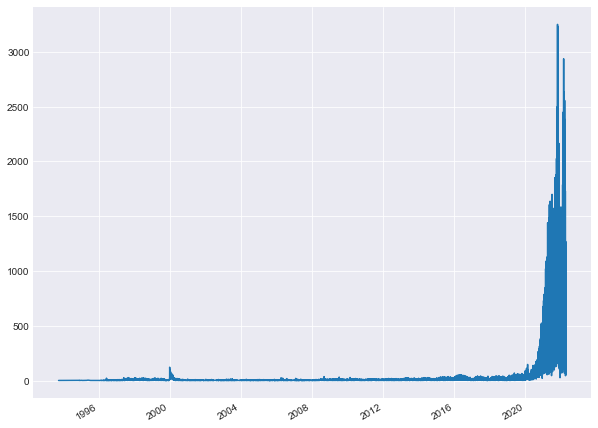

In [163]:
pd.to_datetime(wa_pm_listing["LISTINGCONTRACTDATE"]).value_counts().plot()

<AxesSubplot:>

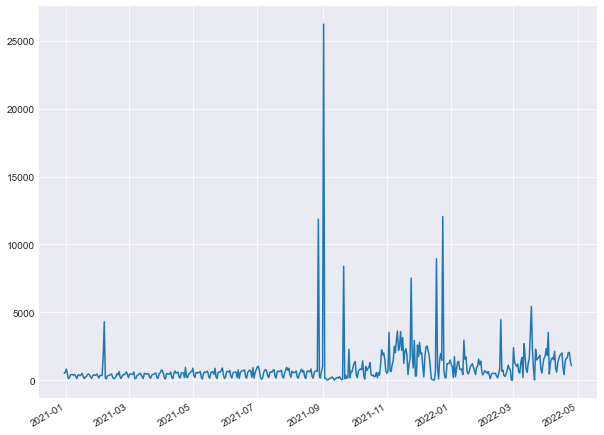

In [162]:
pd.to_datetime(wa_pm_listing["EXTRACT_DATE"]).value_counts().plot()

In [141]:
# LISTAGENTMLSID is the key to merge the data
# MLSLISTINGNUMBER is the key of each listing
wa_pm_listing[[i for i in wa_pm_listing.columns if "MLS" in i]]

,COLISTAGENTMLSID,COLISTOFFICEMLSID,LISTAGENTMLSID,LISTOFFICEMLSID,MLSAREAMAJOR,MLSBOARD,MLSLISTINGNUMBER,MLSSTATUS
0,None,None,105627,4649,340 - Renton/Benson Hi,NWMLS,1268705,Sold
1,None,None,104779,4649,444 - Olympia Westside,NWMLS,1322870,Sold
2,0,0,115760,4649,340 - Renton/Benson Hi,NWMLS,1335254,Sold
3,0,0,115760,4649,540 - East Of Lake Sam,NWMLS,1351166,Cancel/Withdrawn
4,0,0,101518,4649,500 - East Side/South,NWMLS,1385775,Sold
...,...,...,...,...,...,...,...,...
444002,HARDINGK,4PRG01,BORWIECK,4PRG01,Vancouver: S Salmon Creek,RMLS,21394818,Pending
444003,None,None,ITTERJAN,4PLH01,"Clark Co: Brush Prairie, Hockinson",RMLS,21259392,Sold
444004,None,None,CHESTERJ,4CRE01,Vancouver: Sifton,RMLS,21690648,Sold
444005,None,None,1120,67,A210/030,SARMLS,202113325,Cancel/Withdrawn


In [143]:
wa_lead[[i for i in wa_lead.columns if "MLS" in i]]

,AGENT_MLS_ID_C,NMLS_ID_C
452,26650,None
454,98995,None
1264,None,None
1292,94093,None
1297,3839,None
...,...,...
783757,None,None
783914,None,None
784446,None,None
784769,None,None


In [145]:
subset_wa_pm_listing = wa_pm_listing[wa_pm_listing["LISTAGENTMLSID"].isin(wa_lead["AGENT_MLS_ID_C"])]

In [146]:
subset_wa_pm_listing.shape

(101030, 243)

In [148]:
subset_wa_pm_listing["LISTAGENTMLSID"].value_counts()

55676     816
45311     793
39304     403
87431     381
1686      375
         ... 
43888       1
773847      1
118290      1
106379      1
119951      1
Name: LISTAGENTMLSID, Length: 3224, dtype: int64

In [149]:
subset_wa_pm_listing["MLSLISTINGNUMBER"].value_counts()

1841494    16
1857039    15
1863904    15
1863687    14
1860596    13
           ..
1755268     1
1756825     1
1764759     1
1765585     1
1667168     1
Name: MLSLISTINGNUMBER, Length: 66696, dtype: int64

In [153]:
# ORIGINALLISTPRICE records the original price
#
subset_wa_pm_listing[subset_wa_pm_listing["MLSLISTINGNUMBER"] == '1841494']

,index,FILENAME,FILE_ROW_NUMBER,LOAD_DATE,EXTRACT_DATE,VALUE,ABOVEGRADEFINISHEDAREA,ABOVEGRADEFINISHEDAREAUNITS,ADDITIONALPARCELSYN,ADDRESS,AGENTADDRESS,APPLIANCES,ARCHITECTURALSTYLE,ASSOCIATIONFEE,ASSOCIATIONFEEFREQUENCY,ASSOCIATIONFEEINCLUDES,ASSOCIATIONYN,ATTACHEDGARAGEYN,AVAILABILITYDATE,BASEMENT,BASEMENTENTRY,BASEMENTTYPE,BATHROOMSDECIMAL,BATHROOMSFULL,BATHROOMSHALF,BATHROOMSONEQUARTER,BATHROOMSTHREEQUARTER,BATHROOMSTOTALINTEGER,BEDROOMSPOSSIBLE,BEDROOMSTOTAL,BELOWGRADEFINISHEDAREA,BELOWGRADEFINISHEDAREAUNITS,BELOWGRADETOTALAREA,BUILDERNAME,BUILDINGAREATOTAL,BUILDINGAREAUNITS,BUILDINGFEATURES,BUILDINGNAME,BUYERAGENCYCOMPENSATION,BUYERFINANCING,CARSTORAGETYPE,CARPORTYN,CITY,CLASSNAME,CLOSEDATE,CLOSEPRICE,COLISTAGENTMLSID,COLISTOFFICEMLSID,COMMUNITYFEATURES,CONCESSIONS,CONCESSIONSAMOUNT,CONCESSIONSCOMMENTS,CONSTRUCTIONMATERIALS,CONTINGENTDATE,CONTRACTSTATUSCHANGEDATE,COOLING,COOLINGTYPE,COOLINGYN,COUNTRY,COUNTYORPARISH,COVEREDSPACES,CROPSINCLUDEDYN,CUMULATIVEDAYSONMARKET,DATASOURCE,DAYSONMARKET,DIRECTIONS,DISCLOSURES,DISTANCETOBUS,DISTRESSTYPE,DISTRESSEDYN,DOCUMENTSAVAILABLE,DUALVARIABLECOMPENSATIONYN,ELECTRICONPROPERTYYN,ELEMENTARYSCHOOL,ELEMENTARYSCHOOLDISTRICT,ELEVATIONUNITS,ENTRYLOCATION,EXTERIORFEATURES,FIPS,FARMCREDITSERVICEINCLYN,FIREPLACEFEATURES,FIREPLACEYN,FIREPLACESTOTAL,FLIPDURATION,FLIPYN,FLOORING,FURNISHED,GARAGESPACES,GARAGEYN,GATEDCOMMUNITYYN,GRAZINGPERMITSBLMYN,GRAZINGPERMITSFORESTSERVICEYN,GRAZINGPERMITSPRIVATEYN,GREENVERIFICATIONAMERICAN_LUNG_ASSOC_RATINGBODY,GREENVERIFICATIONENERGY_STARBODY,GREENVERIFICATIONEARTH_CRAFT_CERTIFIED_HOMEBODY,GREENVERIFICATIONEARTHCRAFT_HOUSEBODY,GREENVERIFICATIONENVIRONMENTS_FOR_LIVINGBODY,GREENVERIFICATIONENVIRONMENTS_FOR_LIVINGRATING,GREENVERIFICATIONFOREST_STEWARDSHIP_COUNCIL_WOODBODY,GREENVERIFICATIONGREEN_BUILT_NORTH_CAROLINABODY,GREENVERIFICATIONLEEDBODY,GREENVERIFICATIONNAHBBODY,GREENENERGYEFFICIENT,HABITABLERESIDENCEYN,HEATING,HEATINGFUEL,HEATINGTYPE,HEATINGYN,HIGHSCHOOL,HIGHSCHOOLDISTRICT,HOMEWARRANTYYN,HORSEYN,IMAGECOUNT,INCLUSIONS,INTERIORFEATURES,INTERNETADDRESSDISPLAYYN,INTERNETAUTOMATEDVALUATIONDISPLAYYN,INTERNETCONSUMERCOMMENTYN,INTERNETENTIRELISTINGDISPLAYYN,IRRIGATIONWATERRIGHTSYN,LANDLEASEYN,LATITUDE,LEASEASSIGNABLEYN,LEASECONSIDEREDYN,LEASERENEWALOPTIONYN,LEVELS,LISTAGENTEMAIL,LISTAGENTFULLNAME,LISTAGENTKEY,LISTAGENTMLSID,LISTAGENTPREFERREDPHONE,LISTAGENTSTATELICENSE,LISTOFFICEEMAIL,LISTOFFICEKEY,LISTOFFICEMLSID,LISTOFFICENAME,LISTOFFICEPHONE,LISTPRICE,LISTINGCONTRACTDATE,LISTINGID,LISTINGKEY,LISTINGTERMS,LISTINGTYPE,LIVINGAREA,LIVINGAREASOURCE,LIVINGAREAUNITS,LONGITUDE,LOTFEATURES,LOTSIZEACRES,LOTSIZEAREA,LOTSIZEDIMENSIONS,LOTSIZESOURCE,LOTSIZESQUAREFEET,LOTSIZEUNITS,MLSAREAMAJOR,MAINLEVELBEDROOMS,MIDDLEORJUNIORSCHOOL,MIDDLEORJUNIORSCHOOLDISTRICT,MLSBOARD,MLSLISTINGNUMBER,MLSSTATUS,MOBILEHOMEREMAINSYN,MODEL,MODIFICATIONTIMESTAMP,NEWCONSTRUCTIONYN,OCCUPANTNAME,OCCUPANTTYPE,OFFMARKETDATE,OFFMARKETTIMESTAMP,OFFICEADDRESS1,ONMARKETDATE,ONMARKETTIMESTAMP,OPENPARKINGYN,ORIGINALENTRYTIMESTAMP,ORIGINALLISTPRICE,ORIGINATINGSYSTEMNAME,OTHERSTRUCTURES,OWNERNAME,OWNERPHONE,PMXPROPERTYID,PARCELNUMBER,PARKINGFEATURES,PARKINGTOTAL,PATIOANDPORCHFEATURES,PENDINGTIMESTAMP,PHOTOSCHANGETIMESTAMP,PHOTOSCOUNT,POOLFEATURES,POOLPRIVATEYN,POOLTYPE,POSSESSION,POSTALCODE,POSTALCODEPLUS4,PRICEPERSQUAREFEET,PRIVATEREMARKS,PROPMIXMODIFICATIONTIMESTAMP,PROPERTYATTACHEDYN,PROPERTYREFID,PROPERTYSUBTYPE,PROPERTYTYPE,PUBLICREMARKS,PURCHASECONTRACTDATE,RENTCONTROLYN,ROOF,ROOMSTOTAL,SENIORCOMMUNITYYN,SEWER,SHOWINGCONTACTPHONE,SHOWINGINSTRUCTIONS,SIGNONPROPERTYYN,SPAYN,SPECIALLISTINGCONDITIONS,STANDARDSTATUS,STATEORPROVINCE,STATUSCHANGETIMESTAMP,STORIESTOTAL,STREETDIRSUFFIX,STREETNAME,STREETNUMBER,STREETNUMBERNUMERIC,STREETSUFFIX,SUBDIVISIONNAME,TAXANNUALAMOUNT,TAXLEGALDESCRIPTION,TAXYEAR,TOPOGRAPHY,TOTALACTUALRENT,UNITNUMBER,UNPARSEDADDRESS,UTILITIES,VIEW,VIEWYN,WALKSCORE,WATERACCESS,WATERSOURCE,WATERYN,WATERFRONTFEATURES,WATERFRONTYN,YEARBUILT,YEARBUILTEFFECTIVE,YEARBUILTSOURCE,ZONINGDESCRI